# Dominance budgétaire: une approche de similarité des textes
Nous analysons quatres bases de données de discours de deux pays scrapées de la Banque de France, du Ministères de Finances et de la Bundesbank et du Ministère des Finances allemand (2007-2022). L'objectif est de tester l'hypothèse de la [dominance budgétaire](https://fr.wikipedia.org/wiki/Dominance_budg%C3%A9taire), c'est-à-dire la théorie selon laquelle l'autorité budgétaire fixe la trajectoire des déficits publics, que la banque centrale doit ensuite suivre, quelle que soit l'incidence sur le taux d'inflation.

Cette étude vise à fournir des preuves empiriques de cette hypothèse en analysant les discours des institutions financières qui contrôlent les politiques monétaires et fiscales. L'objectif est donc de modéliser une mesure permettant d'évaluer si les discours de l'autorité monétaire suivent celui de l'autorité fisclae dans le temps et de fournir ainsi une preuve empirique de la théorie de la dominance budgétaire. L'utilisation d'une telle mesure quantitative peut ensuite être utilisée de manière économétrique, par exemple pour déterminer quels sont les facteurs économiques qui déterminent la dominance budgétaire.

Nous testons ici différents modèles de similarité de texte supervisés et non  dans le but de créer une mesure de dominance fiscale.



# Nouvelle section

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"
!python -m spacy download fr_core_news_sm # Rédemarrer kernel après installation
!python -m spacy download de_core_news_md
!python -m spacy validate

# Nouvelle section

In [1]:
import os, json
import re
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import spacy
from nltk.stem.snowball import FrenchStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import fr_core_news_sm, de_core_news_md


In [ ]:
# Ne faire fonctionner la cellule que pour passer à un runtime plus élevé
i = []
while(True):
    i.append('a')

In [4]:
path = os.getcwd()+'/drive/MyDrive/Fiscal_Policy_Project/'

In [2]:
# Accéder google drive
try:
    from google.colab import drive
    drive.mount('/content/drive')
except:
    pass

Mounted at /content/drive


In [6]:
import torch

if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device('cpu')

There are 1 GPU(s) available.
Device name: Tesla T4


# Import de données

In [5]:
data_BdF = pd.read_csv(path+'Data/Banque_de_France/data_BdF.csv', index_col=0)
data_MF = pd.read_csv(path+'Data/Ministere_des_finances/data_MF.csv', index_col=0)
data_BB = pd.read_csv(path+'Data/Bundesbank/data_BB.csv', index_col=0)
data_BFM = pd.read_csv(path+'Data/Bundesfinanzministerium/data_BFM.csv', index_col=0)

# Preprocessing

## Séparation de textes en phrases
Nous gardons les points entre les phrases et les chiffres (e.g. 2% pour l'inflation)

In [7]:
def preprocess(txt):
    txt = re.sub(r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))''', " ", txt)
    txt = txt.lower()
    txt = re.sub(r"\s+[a-z]\s+"," ",txt)
    txt = re.sub(r"\s+[a-z]$"," ",txt)
    txt = re.sub(r"^[a-z]\s+"," ",txt)
    txt = re.sub(r"\s+"," ",txt)
    return txt

In [8]:
data_BdF['Processed_text_sentences'] = data_BdF['TEXT'].apply(lambda txt: preprocess(txt))
data_MF['Processed_text_sentences'] = data_MF['TEXT'].apply(lambda txt: preprocess(txt))
data_BB['Processed_text_sentences'] = data_BB['TEXT'].apply(lambda txt: preprocess(txt))
data_BFM['Processed_text_sentences'] = data_BFM['TEXT'].apply(lambda txt: preprocess(txt))

## Séparation de textes par années et trimestres

In [9]:
# Par année
data_BdF['Year'] = pd.to_datetime(data_BdF['DATE']).dt.year
data_MF['Year'] = pd.to_datetime(data_MF['DATE']).dt.year
data_BB['Year'] = pd.to_datetime(data_BB['DATE']).dt.year
data_BFM['Year'] = pd.to_datetime(data_BFM['DATE']).dt.year

In [10]:
data_BdF_year_wise = data_BdF[['Year', 'Processed TEXT', 'Processed_text_sentences']].groupby(['Year']).sum().reset_index()
data_MF_year_wise = data_MF[['Year', 'Processed TEXT', 'Processed_text_sentences']].groupby(['Year']).sum().reset_index()
data_BB_year_wise = data_BB[['Year', 'Processed TEXT', 'Processed_text_sentences']].groupby(['Year']).sum().reset_index()
data_BFM_year_wise = data_BFM[['Year', 'Processed TEXT', 'Processed_text_sentences']].groupby(['Year']).sum().reset_index()

In [11]:
# Par trimestre
data_BdF['Quarter'] = pd.PeriodIndex(data_BdF.DATE, freq='Q').to_timestamp()
data_MF['Quarter'] = pd.PeriodIndex(data_MF.DATE, freq='Q').to_timestamp()
data_BB['Quarter'] = pd.PeriodIndex(data_BB.DATE, freq='Q').to_timestamp()
data_BFM['Quarter'] = pd.PeriodIndex(data_BFM.DATE, freq='Q').to_timestamp()

In [12]:
data_BdF_quarter_wise = data_BdF[['Quarter', 'Processed TEXT', 'Processed_text_sentences']].groupby(['Quarter']).sum().reset_index()
data_MF_quarter_wise = data_MF[['Quarter', 'Processed TEXT', 'Processed_text_sentences']].groupby(['Quarter']).sum().reset_index()
data_BB_quarter_wise = data_BB[['Quarter', 'Processed TEXT', 'Processed_text_sentences']].groupby(['Quarter']).sum().reset_index()
data_BFM_quarter_wise = data_BFM[['Quarter', 'Processed TEXT', 'Processed_text_sentences']].groupby(['Quarter']).sum().reset_index()

## Stopwords

In [13]:
# Créations d'une liste de stopwords

stopwords_fr = set(line.strip() for line in open(path+'/Descriptive_analysis/stopwords-fr.txt', encoding="utf-8"))
stopwords_de = set(line.strip() for line in open(path+'/Descriptive_analysis/stopwords-de.txt', encoding="utf-8"))

# Rajout de stopwords français
stopwords_fr = stopwords_fr.union(set(["christine","lagarde","christian","noyer","villeroy","hedwige","christophe","jean","pierre",
                                 "françois","galhau", "jakubyszyn", "chevrillon", "eric", "mabrouk", "marc", "silvestre", "hervé",
                                 "mark", "deen", "fr", "bruno", "maire", "copyright", "michel", "sapin", "anne", "marie", "mesdames",
                                 "messieurs", "madame", "monsieur", "elkabbach", "page", "novelli", "besson"]))

stopwords_de = stopwords_de.union(set(["de", "angabe", "straße", "seite", "main", "frankfurt", "mail", "quelle", "information",
                                       "publizistischer", "epstein", "fax", "presse", "wilhelm", "the", "œ", "damen", "herren", "christian",
                                       "lindner", "olaf", "scholz", "herr", "schäuble", "mez", "mesz", "gesprochene", "gilt", "wort",
                                       "and", "of", "sendesperrfrist", "di", "ge", "be", "gen", "ten", "wolfgang", "hoeneß",
                                       "wams", "bams", "swr","bild","spd","fdp", "grüne", "grünen", "sonntag", "cdu","csu",
                                       "spiegel", "spahn", "handelsblatt", "frankfurter", "allgemeine", "ralph", "sz", "zeitung",
                                       "osnabrücker", "deutschlandfunk", "sonntagszeitung", "luther", "bollmann",
                                       "peter", "willy", "rheinische", "brandt", "focus", "tagesspiegel", "welt"]))


## Lags

In [14]:
# Définir lags
lag_years = 0
lag_months = 0

# Jaccard Similiarity

L’indice de Jaccard est mesuré en divisant le nombre de mots partagés par les deux textes par le nombre total de mots :



$\text{J}({V_{1},V_{2}}) = \frac{V_{1}\cap V_{2}}{V_{1} \cup V_{2} } $




où :

$\text{J}$ est la distance de Jaccard

$V_{1}$, $V_{2}$ les vecteurs de mots à comparer


In [ ]:
from nltk.stem.snowball import SnowballStemmer

french_stemmer = FrenchStemmer()
german_stemmer = SnowballStemmer("german")

def lemmatize_words_fr(text):
    words = text.split()
    words = [french_stemmer.stem(word) for word in words if word not in stopwords_fr]
    return ' '.join(words)

def lemmatize_words_german(text):
    words = text.split()
    words = [german_stemmer.stem(word) for word in words if word not in stopwords_de]
    return ' '.join(words)

In [ ]:
data_BdF_year_wise['Lemmatized TEXT'] = data_BdF_year_wise['Processed TEXT'].apply(lemmatize_words_fr)
data_MF_year_wise['Lemmatized TEXT'] = data_MF_year_wise['Processed TEXT'].apply(lemmatize_words_fr)
data_BB_year_wise['Lemmatized TEXT'] = data_BB_year_wise['Processed TEXT'].apply(lemmatize_words_german)
data_BFM_year_wise['Lemmatized TEXT'] = data_BFM_year_wise['Processed TEXT'].apply(lemmatize_words_german)

In [ ]:
data_BdF_quarter_wise['Lemmatized TEXT'] = data_BdF_quarter_wise['Processed TEXT'].apply(lemmatize_words_fr)
data_MF_quarter_wise['Lemmatized TEXT'] = data_MF_quarter_wise['Processed TEXT'].apply(lemmatize_words_fr)
data_BB_quarter_wise['Lemmatized TEXT'] = data_BB_quarter_wise['Processed TEXT'].apply(lemmatize_words_german)
data_BFM_quarter_wise['Lemmatized TEXT'] = data_BFM_quarter_wise['Processed TEXT'].apply(lemmatize_words_german)

In [ ]:
from nltk.metrics import jaccard_distance

# Function pour calculer Jaccard similarity
def jaccard_similarity(text1, text2):
    set1 = set(text1.lower().split())
    set2 = set(text2.lower().split())
    return 1 - jaccard_distance(set1, set2)

def get_match_and_score(first_df, second_df):

    # Itérer sur les lignes de df1 et trouver le texte le plus similaire dans df2
    first_df['Jaccard_Matched_Text'] = ''
    first_df['Jaccard_Matched_score'] = ''
    for index, row in first_df.iterrows():
        text = row['Lemmatized TEXT']

        if "Year" in second_df:
          to_match_with = second_df[second_df['Year'] == int(row['Year'])+lag_years]
          duration = 'Year'
        if "Quarter" in second_df:
          new_date = row['Quarter'] + relativedelta(months=0)
          to_match_with = second_df[second_df['Quarter'] == new_date]
          duration = 'Quarter'

        #print(row[duration], " is matched with ", to_match_with[duration].values)

        if to_match_with.shape[0] != 0:
            similarity = jaccard_similarity(text, to_match_with['Lemmatized TEXT'].values.flatten()[0])
            first_df.at[index, 'Jaccard_Matched_Text'] = to_match_with['Lemmatized TEXT'].values.flatten()[0]
        else:
            similarity = 0
            first_df.at[index, 'Jaccard_Matched_Text'] = "No Text"

        first_df.at[index, 'Jaccard_Matched_score'] = similarity

    return first_df

## Jaccard Similarity on Data

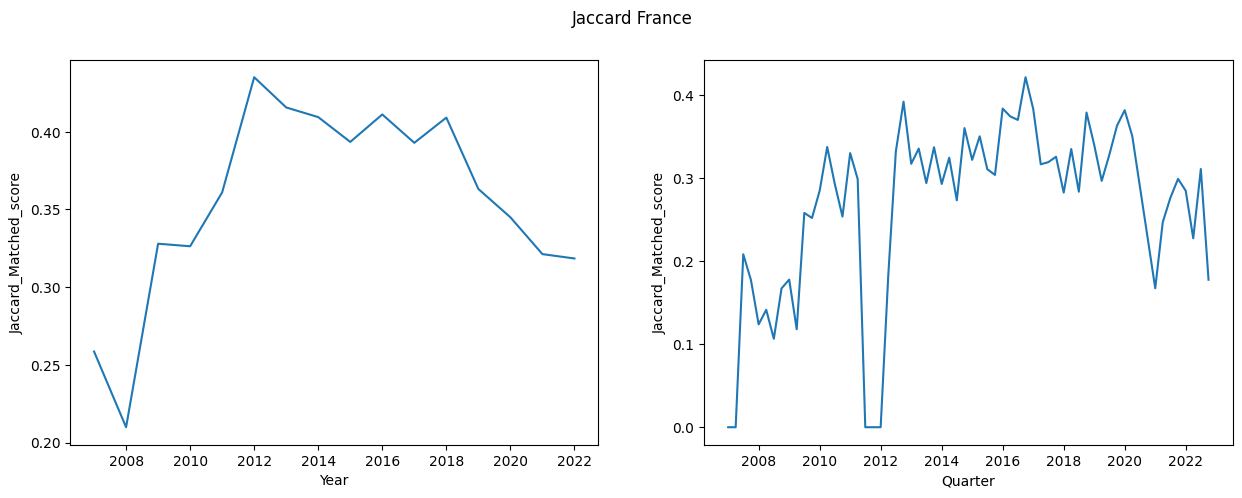

In [ ]:
France_jaccard_y = get_match_and_score(data_BdF_year_wise, data_MF_year_wise)
France_jaccard_q = get_match_and_score(data_BdF_quarter_wise, data_MF_quarter_wise)

fig = plt.figure(figsize=(15,5))
plt.subplot(121)
sns.lineplot(data=France_jaccard_y, x='Year', y='Jaccard_Matched_score');

plt.subplot(122)
sns.lineplot(data=France_jaccard_q, x='Quarter', y='Jaccard_Matched_score')
fig.suptitle('Jaccard France', fontsize=12);

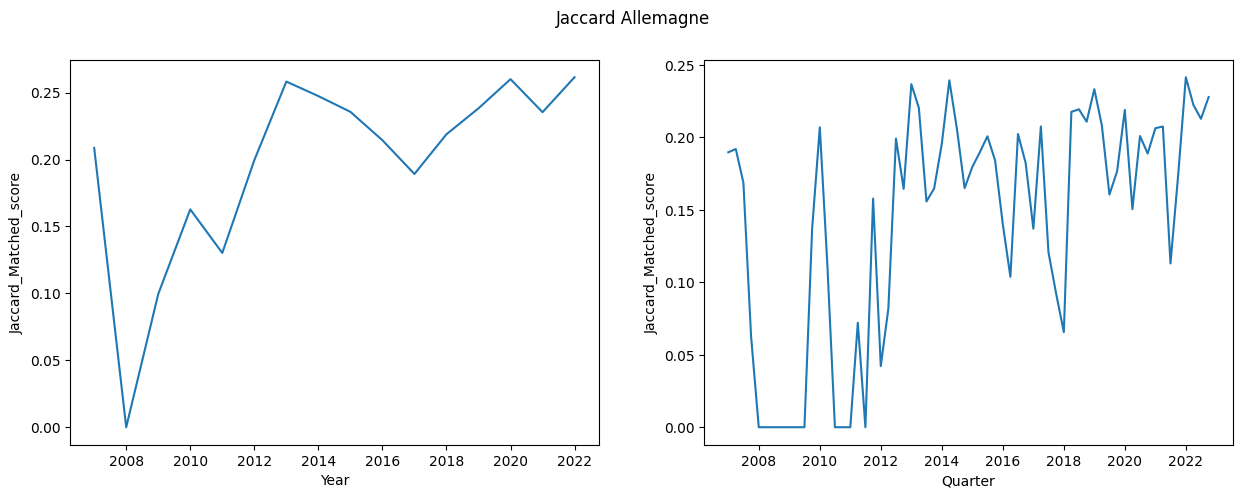

In [ ]:
Germany_jaccard_y = get_match_and_score(data_BB_year_wise, data_BFM_year_wise)
Germany_jaccard_q = get_match_and_score(data_BB_quarter_wise, data_BFM_quarter_wise)

fig = plt.figure(figsize=(15,5))
plt.subplot(121)
sns.lineplot(data=Germany_jaccard_y, x='Year', y='Jaccard_Matched_score');

plt.subplot(122)
sns.lineplot(data=Germany_jaccard_q, x='Quarter', y='Jaccard_Matched_score')
fig.suptitle('Jaccard Allemagne', fontsize=12);

## Trouver les phrase les plus similaire et dissimilaire

# TF-IDF + Jaccard

Le TF-IDF est une méthode de pondération statistique qui permet d'évaluer l'importance d'un terme contenu dans un document, relativement à une collection ou un corpus. La fréquence des termes, $\text{tf}({t,d})$, est la fréquence relative du terme $\textit{t}$ dans le document $\textit{d}$,</br>

$\text{tf}({t,d}) = \dfrac{f_{t,d}}{\sum_{t^{'}\in d} f_{t^{'},d}}$

où $\mathit{f_{t,d}}$ est le nombre d'un terme dans un document, c'est-à-dire le nombre de fois que le terme $\mathit{t}$ apparaît dans le document $\textit{d}$.</br>

Nous allons vectoriser nos textes avec la méthode TF-IDF et comparer les textes toujours en utilisant Jaccard.

### Score global :

In [ ]:
# Définition d'une fonction pour vectoriser nos données
def TF_IDF(data,stopw):
    tfidf = TfidfVectorizer(max_df=0.95, min_df=2,stop_words=list(stopw))
    dtm=tfidf.fit_transform(data['Processed TEXT'])
    return tfidf,dtm


In [ ]:
# Application de la fonction aux données de la Banque de France
vectorizer_BdF,dtm_BdF=TF_IDF(data_BdF,stopwords_fr)

# Application de la fonction aux données du Ministère Français
vectorizer_MF,dtm_MF=TF_IDF(data_MF,stopwords_fr)

# Application de la fonction aux données de la Bundesbank
vectorizer_BB,dtm_BB=TF_IDF(data_BB,stopwords_de)

# Application de la fonction aux données du Ministère des Finances allemand
vectorizer_BFM,dtm_BFM=TF_IDF(data_BFM,stopwords_de)

In [ ]:
#Définir la fonction jaccard
def jaccard(list1, list2):
    intersection = len(list(set(list1).intersection(list2)))
    union = (len(list1) + len(list2)) - intersection
    return float(intersection) / union

In [ ]:
#France :

v1 = list(vectorizer_MF.vocabulary_.keys())
v2 = list(vectorizer_BdF.vocabulary_.keys())

print(jaccard(v1, v2))

#Allemagne :

v3 = list(vectorizer_BB.vocabulary_.keys())
v4 = list(vectorizer_BFM.vocabulary_.keys())

print(jaccard(v3, v4))

0.4687332315185537
0.28603176678214265


Nous avons un premier score de 0.47 de similarité entre les discours de la BDF et le Ministère Français et de 0.29 entre la Bundesbank et le Ministère Allemand. C'est une note globale de similarité lexicale entre les 2 discours. Nous allons maintenant comparer la similarité des discours année par année.

### Jaccard Similarity par Année

In [ ]:
# Définir une nouvelle fonction TF-IDF pour traiter chaque groupement de discours

def TF_IDF_discours(data,stopw):
  vectorizer = TfidfVectorizer()
  X = vectorizer.fit_transform(data['Processed TEXT'])
  return list(vectorizer.vocabulary_.keys())

In [ ]:
# Appliquer le vectorization TF-IDF sur chaque discours

#France
data_BdF_year_wise['Text Vectorized'] = [TF_IDF_discours(data_BdF_year_wise.iloc[[index]],stopwords_fr)
                                          for index in list(data_BdF_year_wise.index)]

data_MF_year_wise['Text Vectorized'] = [TF_IDF_discours(data_MF_year_wise.iloc[[index]],stopwords_fr)
                                          for index in list(data_MF_year_wise.index)]

#Allemagne
data_BB_year_wise['Text Vectorized'] = [TF_IDF_discours(data_BB_year_wise.iloc[[index]],stopwords_fr)
                                          for index in list(data_BB_year_wise.index)]

data_BFM_year_wise['Text Vectorized'] = [TF_IDF_discours(data_BFM_year_wise.iloc[[index]],stopwords_fr)
                                          for index in list(data_BFM_year_wise.index)]

In [ ]:
# Rajouter l'année 2008 au Dataframe de BFM :

line = pd.DataFrame({'Year': [2008], 'Processed TEXT': [''], 'Text Vectorized': [[]]})

data_BFM_year_wise = pd.concat([data_BFM_year_wise, line]).sort_values(by = 'Year').reset_index(drop=True)

In [ ]:
# calcul de la similarité :

comparaison_annee_fr = data_BdF_year_wise
comparaison_annee_de = data_BB_year_wise

comparaison_annee_fr['Jaccard Score'] = [jaccard(v1, v2) for (v1, v2) in zip(data_BdF_year_wise['Text Vectorized'],data_MF_year_wise['Text Vectorized'])]
comparaison_annee_de['Jaccard Score'] = [jaccard(v1, v2) for (v1, v2) in zip(data_BB_year_wise['Text Vectorized'],data_BFM_year_wise['Text Vectorized'])]

In [ ]:
print('Jaccard Score France : ', comparaison_annee_fr['Jaccard Score'].mean())
print('Jaccard Score Allemagne : ',comparaison_annee_de['Jaccard Score'].mean())

Jaccard Score France :  0.3012497386429227
Jaccard Score Allemagne :  0.18976565977634666


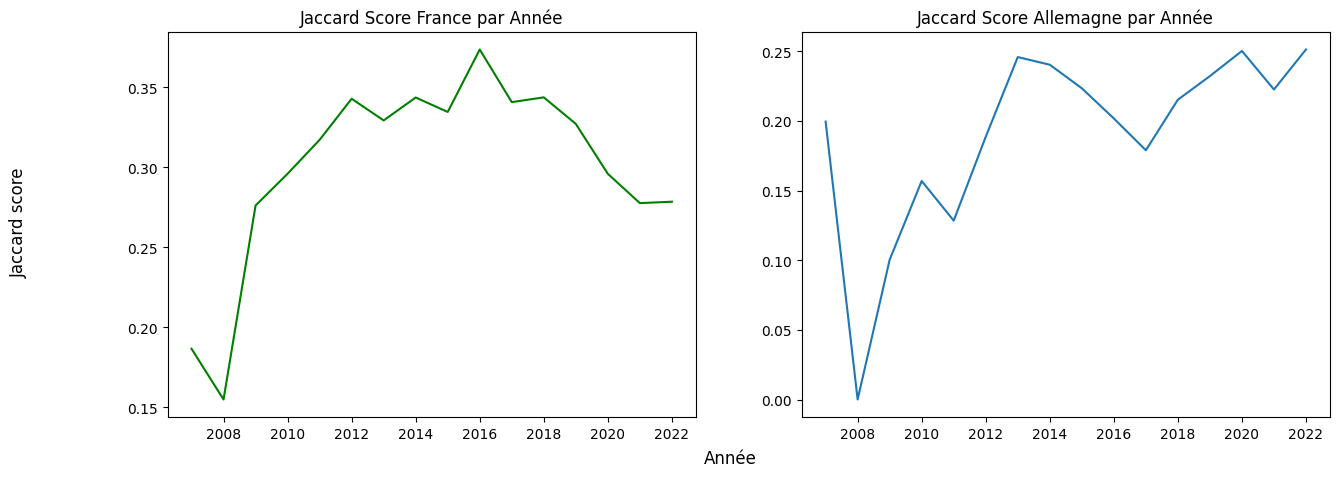

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))

ax1.plot(comparaison_annee_fr['Year'], comparaison_annee_fr['Jaccard Score'], 'g')
ax1.title.set_text('Jaccard Score France par Année')

ax2.plot(comparaison_annee_de['Year'], comparaison_annee_de['Jaccard Score'])
ax2.title.set_text('Jaccard Score Allemagne par Année')

fig.supxlabel('Année')
fig.supylabel('Jaccard score')

plt.show();

On se retrouve avec un score moyen de 0.3 pour la France qui est inférieur au score global. Ce qui est intéressant à signaler d'après le graphe de l'évolution du score de Jaccard c'est que la Banque de France et le Ministère des finances commencent à utiliser plus de chanmp lexical commun à partir de l'année 2009 avec un pic en 2016. Toutefois, cela ne nous rapporte pas beaucoup d'informations sur la réelle similarité entre les 2 types de discours.

Nous voulons maintenant tester l'hypothèse de la dominance budgétaire en regroupant cette fois les discours par trimestre et en calculant la similarité entre le texte de la BdF d'une trimestre T et le texte de la MF de la trimestre T-1. On veut tester si on se trouve avec un des scores plus elevés et si c'est le cas on peut en déduire que les discours de la MF influence les discours de la BdF.

### Jaccard Similarity par Trimestre

In [ ]:
#A rajouter dans le preprocessing des données

data_BdF['DATE'] = pd.to_datetime(data_BdF["DATE"], format='%Y-%m-%d')
data_MF['DATE'] = pd.to_datetime(data_MF["DATE"], format='%Y-%m-%d')
data_BB['DATE'] = pd.to_datetime(data_BB["DATE"], format='%Y-%m-%d')
data_BFM['DATE'] = pd.to_datetime(data_BFM["DATE"], format='%Y-%m-%d')

In [ ]:
data_BdF['Quarter'] = data_BdF['DATE'].dt.to_period("Q")
data_MF['Quarter'] = data_MF['DATE'].dt.to_period("Q")
data_BB['Quarter'] = data_BB['DATE'].dt.to_period("Q")
data_BFM['Quarter'] = data_BFM['DATE'].dt.to_period("Q")

In [ ]:
data_BdF['DATE Quarter'] = pd.PeriodIndex(data_BdF.DATE, freq='Q').to_timestamp()
data_MF['DATE Quarter'] = pd.PeriodIndex(data_MF.DATE, freq='Q').to_timestamp()

data_BB['DATE Quarter'] = pd.PeriodIndex(data_BB.DATE, freq='Q').to_timestamp()
data_BFM['DATE Quarter'] = pd.PeriodIndex(data_BFM.DATE, freq='Q').to_timestamp()

In [ ]:
# Regroupement des textes par trimestre :
# France
data_BdF_quarter_wise = data_BdF[['Quarter','DATE Quarter', 'Processed TEXT']].groupby(['Quarter', 'DATE Quarter']).sum().reset_index().sort_values(by = 'Quarter')
data_MF_quarter_wise = data_MF[['Quarter','DATE Quarter', 'Processed TEXT']].groupby(['Quarter', 'DATE Quarter']).sum().reset_index().sort_values(by = 'Quarter')

#Allemagne
data_BB_quarter_wise = data_BB[['Quarter','DATE Quarter', 'Processed TEXT']].groupby(['Quarter', 'DATE Quarter']).sum().reset_index().sort_values(by = 'Quarter')
data_BFM_quarter_wise = data_BFM[['Quarter','DATE Quarter', 'Processed TEXT']].groupby(['Quarter', 'DATE Quarter']).sum().reset_index().sort_values(by = 'Quarter')

In [ ]:
# Appliquer le vectorization TF-IDF sur chaque discours

data_BdF_quarter_wise['Text Vectorized'] = [TF_IDF_discours(data_BdF_quarter_wise.iloc[[index]],stopwords_fr)
                                          for index in list(data_BdF_quarter_wise.index)]

data_MF_quarter_wise['Text Vectorized'] = [TF_IDF_discours(data_MF_quarter_wise.iloc[[index]],stopwords_fr)
                                          for index in list(data_MF_quarter_wise.index)]

# Allemagne :
data_BB_quarter_wise['Text Vectorized'] = [TF_IDF_discours(data_BB_quarter_wise.iloc[[index]],stopwords_de)
                                          for index in list(data_BB_quarter_wise.index)]

data_BFM_quarter_wise['Text Vectorized'] = [TF_IDF_discours(data_BFM_quarter_wise.iloc[[index]],stopwords_de)
                                          for index in list(data_BFM_quarter_wise.index)]

In [ ]:
#Définir une fonction pour rajouter le texte du trimestre précédent dans le dataframe :

def precedent_period(df1, df2) :
  df1['Text2 Vectorized'] = ""
  for i in range(0,len(df1)) :
    period = df1.iloc[i]['Quarter']-1
    if period in df2['Quarter'].values :
      df1['Text2 Vectorized'][i]= df2[df2['Quarter'] == period]['Text Vectorized'].values[0]
  return df1

In [ ]:
# Comparaison chaque discours de la BdF d'une trimestre avec les discours du trimestre précèdent de la MF :

comparaison_discours_fr = precedent_period(data_BdF_quarter_wise, data_MF_quarter_wise)
comparaison_discours_de = precedent_period(data_BB_quarter_wise, data_BFM_quarter_wise)

In [ ]:
# Appliquer le score de Jaccard :

comparaison_discours_fr['Jaccard Score'] = [jaccard(v1, v2) for (v1, v2) in zip(comparaison_discours_fr['Text Vectorized'],comparaison_discours_fr['Text2 Vectorized'])]

comparaison_discours_de['Jaccard Score'] = [jaccard(v1, v2) for (v1, v2) in zip(comparaison_discours_de['Text Vectorized'],comparaison_discours_de['Text2 Vectorized'])]

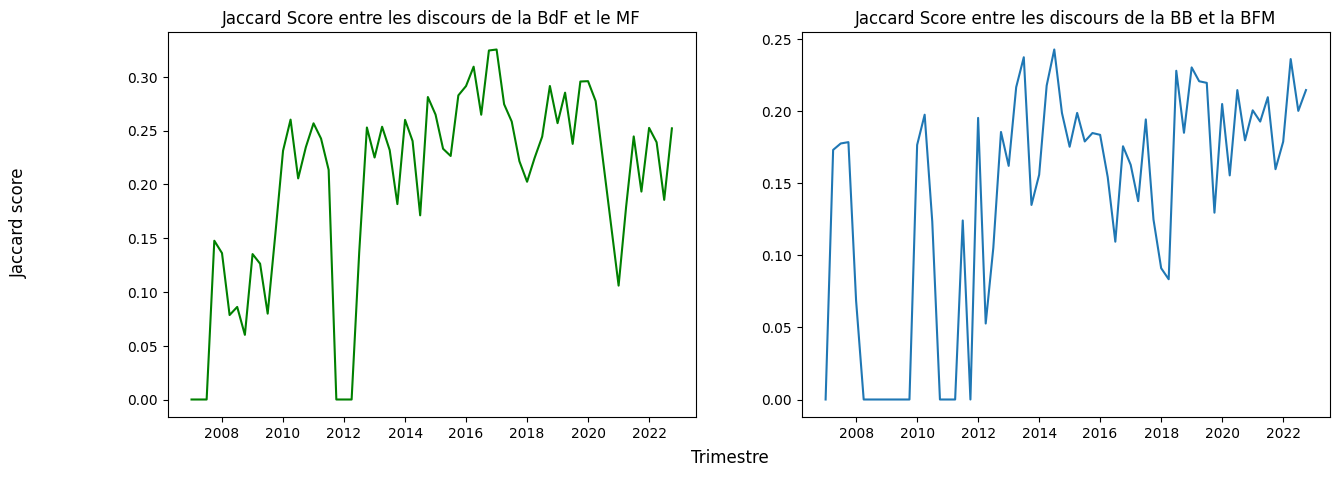

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))

ax1.plot(comparaison_discours_fr['DATE Quarter'], comparaison_discours_fr['Jaccard Score'], 'g')
ax1.title.set_text('Jaccard Score entre les discours de la BdF et le MF')

ax2.plot(comparaison_discours_de['DATE Quarter'], comparaison_discours_de['Jaccard Score'])
ax2.title.set_text('Jaccard Score entre les discours de la BB et la BFM')

fig.supxlabel('Trimestre')
fig.supylabel('Jaccard score')

plt.show();

# TF-IDF + K-means

Le partitionnement en k-moyennes (ou k-means) est une méthode de clustering (regroupement de données). Étant donnés des points et un entier $\text{k}$ , l'algorithme vise à diviser les points en k groupes, appelés clusters, homogènes et compacts.</br>
Ici nous allons attribuer des clusters aux points de données dans les dataframes.

In [ ]:
nlp_fr = spacy.load('fr_core_news_sm')
nlp_de = spacy.load('de_core_news_md')

In [ ]:
nlp_fr.max_length = 2000000
nlp_de.max_length = 2000000

## Preprocessing lemmaitization
Utilisez les fichiers pickle directement. Ils incluent les textes lemmatisés et sans stop-words

In [ ]:
def preprocess_text_fr(text):
    doc = nlp_fr(text)
    preprocessed_text = ' '.join([token.lemma_.lower() for token in doc if not token.is_stop and token.is_alpha])
    return preprocessed_text

def preprocess_text_de(text):
    doc = nlp_de(text)
    preprocessed_text = ' '.join([token.lemma_.lower() for token in doc if not token.is_stop and token.is_alpha])
    return preprocessed_text

In [ ]:
 # Preprocess text in both dataframes
data_BdF_year_wise['Preprocessed_Text'] = data_BdF_year_wise['Processed TEXT'].apply(preprocess_text_fr)
data_MF_year_wise['Preprocessed_Text'] = data_MF_year_wise['Processed TEXT'].apply(preprocess_text_fr)

NameError: ignored

In [ ]:
data_BdF_quarter_wise['Preprocessed_Text'] = data_BdF_quarter_wise['Processed TEXT'].apply(preprocess_text_fr)
data_MF_quarter_wise['Preprocessed_Text'] = data_MF_quarter_wise['Processed TEXT'].apply(preprocess_text_fr)

In [ ]:
# Sauvegarde sous pickle
with open(path+'Data/Intermediate_Data/data_BdF_year_wise.pickle','wb') as f:
    pickle.dump(data_BdF_year_wise,f)
with open(path+'Data/Intermediate_Data/data_MF_year_wise.pickle','wb') as f:
    pickle.dump(data_MF_year_wise,f)

In [ ]:
# Sauvegarde sous pickle
with open(path+'Data/Intermediate_Data/data_BdF_quarter_wise.pickle','wb') as f:
    pickle.dump(data_BdF_quarter_wise,f)
with open(path+'Data/Intermediate_Data/data_MF_quarter_wise.pickle','wb') as f:
    pickle.dump(data_MF_quarter_wise,f)

In [ ]:
data_BB_year_wise['Preprocessed_Text'] = data_BB_year_wise['Processed TEXT'].apply(preprocess_text_de)
data_BFM_year_wise['Preprocessed_Text'] = data_BFM_year_wise['Processed TEXT'].apply(preprocess_text_de)

In [ ]:
data_BB_quarter_wise['Preprocessed_Text'] = data_BB_quarter_wise['Processed TEXT'].apply(preprocess_text_de)
data_BFM_quarter_wise['Preprocessed_Text'] = data_BFM_quarter_wise['Processed TEXT'].apply(preprocess_text_de)

In [ ]:
# Sauvegarde sous pickle
with open(path+'Data/Intermediate_Data/data_BB_year_wise.pickle','wb') as f:
    pickle.dump(data_BB_year_wise,f)
with open(path+'Data/Intermediate_Data/data_BFM_year_wise.pickle','wb') as f:
    pickle.dump(data_BFM_year_wise,f)

In [ ]:
with open(path+'Data/Intermediate_Data/data_BB_quarter_wise.pickle','wb') as f:
    pickle.dump(data_BB_quarter_wise,f)
with open(path+'Data/Intermediate_Data/data_BFM_quarter_wise.pickle','wb') as f:
    pickle.dump(data_BFM_quarter_wise,f)

## Load pickled files

In [ ]:
# Par année
with open(path+'Data/Intermediate_Data/data_BdF_year_wise.pickle','rb') as f:
  data_BdF_year_wise=pickle.load(f)
with open(path+'Data/Intermediate_Data/data_MF_year_wise.pickle','rb') as f:
  data_MF_year_wise=pickle.load(f)
with open(path+'Data/Intermediate_Data/data_BB_year_wise.pickle','rb') as f:
  data_BB_year_wise=pickle.load(f)
with open(path+'Data/Intermediate_Data/data_BFM_year_wise.pickle','rb') as f:
  data_BFM_year_wise=pickle.load(f)

In [ ]:
# Par trimestre
with open(path+'Data/Intermediate_Data/data_BdF_quarter_wise.pickle','rb') as f:
  data_BdF_quarter_wise=pickle.load(f)
with open(path+'Data/Intermediate_Data/data_MF_quarter_wise.pickle','rb') as f:
  data_MF_quarter_wise=pickle.load(f)
with open(path+'Data/Intermediate_Data/data_BB_quarter_wise.pickle','rb') as f:
  data_BB_quarter_wise=pickle.load(f)
with open(path+'Data/Intermediate_Data/data_BFM_quarter_wise.pickle','rb') as f:
  data_BFM_quarter_wise=pickle.load(f)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

def kmean_match(first_df, second_df):
    # Réunir les textes prétraités des deux dataframes
    all_texts = first_df['Preprocessed_Text'].fillna("").tolist() + second_df['Preprocessed_Text'].fillna("").tolist()

    # Vectorizer les textes prétraités avec TF-IDF
    vectorizer = TfidfVectorizer()
    feature_matrix = vectorizer.fit_transform(all_texts)

    # Aplication de K-means clustering
    k = 1  # Nombres de clusters (1 pour trouver le texte le plus similaire)
    kmeans = KMeans(n_clusters=k)
    cluster_labels = kmeans.fit_predict(feature_matrix)

    # Attribution d'un cluster label aux points de données
    first_df['Cluster_Label'] = cluster_labels[:len(first_df)]
    second_df['Cluster_Label'] = cluster_labels[len(first_df):]

    # Faire correspondre les valeurs et calculer la similarity
    first_df['KMeans_Embedding_Matched_Text'] = ''
    first_df['KMeans_Embedding_Matched_Score'] = ''

    for i, row in first_df.iterrows():
        cluster_label = row['Cluster_Label']

        if "Year" in second_df:
          duration = 'Year'
          matching_rows = second_df[(second_df['Year'] == int(row['Year'])+lag_years) & (second_df['Cluster_Label'] == cluster_label)][['Preprocessed_Text']]
        if "Quarter" in second_df:
          new_date = row['Quarter'] + relativedelta(months=lag_months)
          duration = 'Quarter'
          matching_rows = second_df[(second_df['Quarter'] == new_date) & (second_df['Cluster_Label'] == cluster_label)][['Preprocessed_Text']]
        similarity_scores = []

        for j, match_row in matching_rows.iterrows():
            # Calculer la similarity en tant que distance entre les embeddings
            similarity_score = cosine_similarity(
                        vectorizer.transform([row['Preprocessed_Text']]),
                        vectorizer.transform([match_row['Preprocessed_Text']])
                        )[0][0]
            similarity_scores.append((similarity_score, match_row['Preprocessed_Text']))

        if similarity_scores:
            best_match_index = max(range(len(similarity_scores)), key=lambda i: similarity_scores[i][0])
            best_match = similarity_scores[best_match_index][1]
            best_score = similarity_scores[best_match_index][0]
        else:
            best_match = ''
            best_score = 0.0

        first_df.at[i, 'KMeans_Embedding_Matched_Text'] = best_match
        first_df.at[i, 'KMeans_Embedding_Matched_Score'] = best_score

    # Output nouveau dataframe
    return first_df

## Kmeans on Data

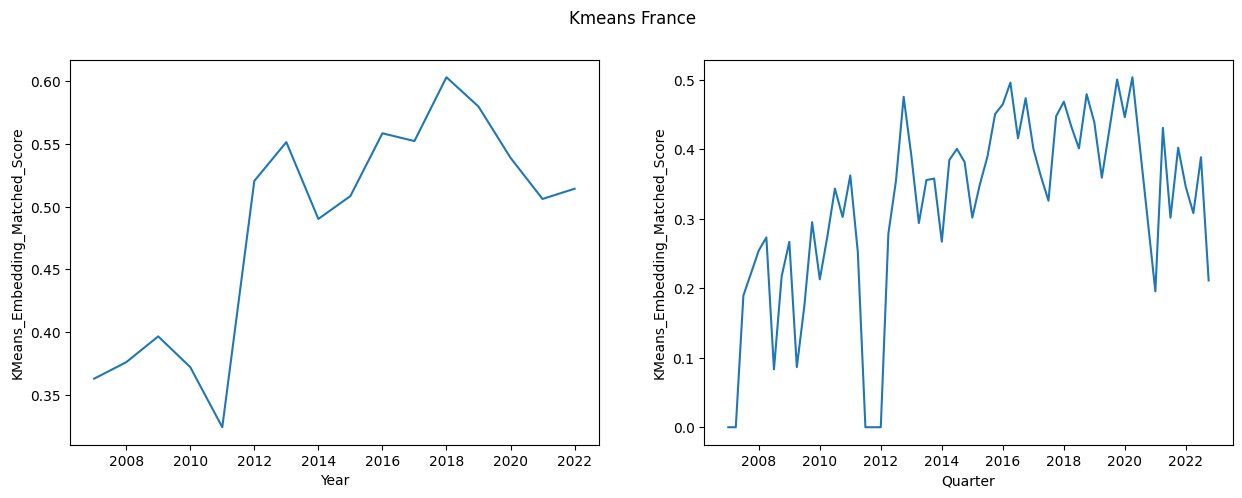

In [ ]:
France_kmeans_y = kmean_match(data_BdF_year_wise, data_MF_year_wise)
France_kmeans_q = kmean_match(data_BdF_quarter_wise, data_MF_quarter_wise)

fig = plt.figure(figsize=(15,5))
plt.subplot(121)
sns.lineplot(data=France_kmeans_y, x='Year', y='KMeans_Embedding_Matched_Score');

plt.subplot(122)
sns.lineplot(data=France_kmeans_q, x='Quarter', y='KMeans_Embedding_Matched_Score')
fig.suptitle('Kmeans France', fontsize=12);


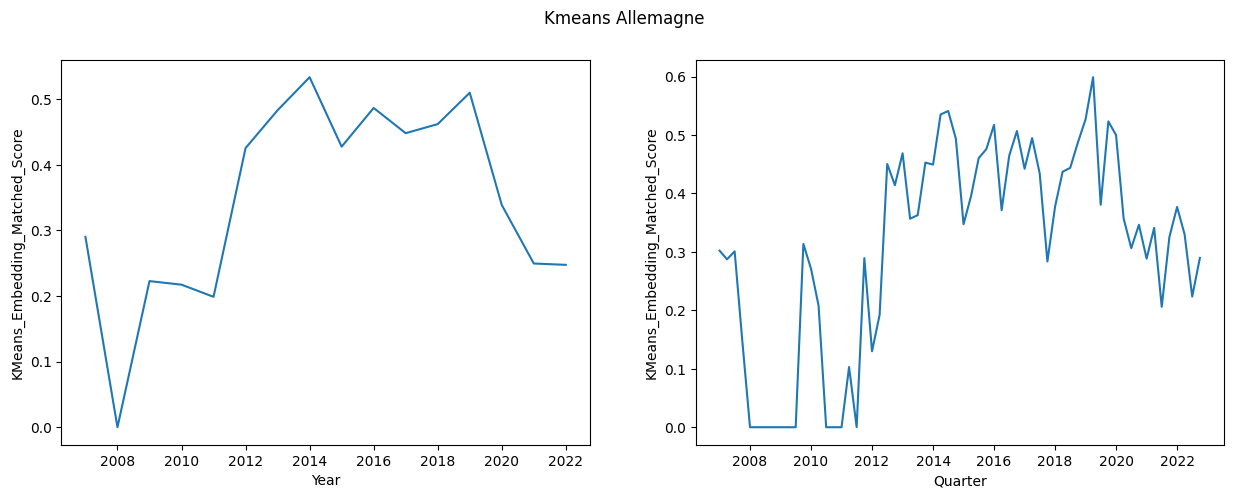

In [ ]:
Germany_kmeans_y = kmean_match(data_BB_year_wise, data_BFM_year_wise)
Germany_kmeans_q = kmean_match(data_BB_quarter_wise, data_BFM_quarter_wise)

fig = plt.figure(figsize=(15,5))
plt.subplot(121)
sns.lineplot(data=Germany_kmeans_y, x='Year', y='KMeans_Embedding_Matched_Score');

plt.subplot(122)
sns.lineplot(data=Germany_kmeans_q, x='Quarter', y='KMeans_Embedding_Matched_Score');
fig.suptitle('Kmeans Allemagne', fontsize=12);


# GloVe + Cosine Similarity


La similarité cosinus donne la similarité de deux vecteurs à $n$ dimensions en déterminant le cosinus de leur angle. Soit deux vecteurs $A$ et $B$, le cosinus de leur angle $θ$ s'obtient en prenant leur produit scalaire divisé par le produit de leurs normes :</br>
$cos \mathit{θ} = \frac{x \cdot y}{|x||y|}$
</br>
La valeur d'un cosinus, donc celle calculée ici pour $cos$ $\mathit{θ}$, est comprise dans l'intervalle [-1,1]. La valeur de -1 indique des vecteurs opposés, la valeur de 0 des vecteurs indépendants (orthogonaux) et la valeur de 1 des vecteurs colinéaires de coefficient positif. Les valeurs intermédiaires permettent d'évaluer le degré de similarité.</br>

Ici nous allons teste la similarité Cosine après avoir vectoisé nos données avec [GloVe](https://nlp.stanford.edu/projects/glove/.
)

Note to self: check this with lemmatized text

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import torch
from torchtext.vocab import GloVe

# Chargement des vecteurs GloVe pré-entraînés
glove_vectors = GloVe(name='6B', dim=300)  # Modification '6B' avec version GloVe et dimension

.vector_cache/glove.6B.zip: 862MB [02:41, 5.35MB/s]                           
100%|█████████▉| 399999/400000 [00:44<00:00, 9048.53it/s]


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import scipy
import torch
from torchtext.vocab import GloVe

# Fonction permettant de convertir un texte en vecteurs de mots à l'aide de GloVe
def convert_to_feature(text):
    word_vectors = []
    for token in text.split():
        if token in glove_vectors.stoi:
                vector = glove_vectors.vectors[glove_vectors.stoi[token]].numpy()
                word_vectors.append(vector)
    return word_vectors


# Fonction permettant de calculer la Cosine similarity entre deux textes
def cosine_similarity_text(text1, text2):
    # Convertir les textes en vecteurs de mots à l'aide des embeddings pré-entraînés
    vector1 = convert_to_feature(text1)
    vector2 = convert_to_feature(text2)
    # Convertir les vecteurs en numpy arrays
    vector1 = np.array(vector1)
    vector2 = np.array(vector2)
    # Calculer cosine similarity entre les vecteurs
    similarity = cosine_similarity(vector1, vector2)
    return similarity

In [ ]:
def match_cosine_similarity(df1, df2):
    # Match each text from the first dataframe with the most similar text in the second dataframe
    df1['Cosine_glove_embedding_Matched_Text'] = ''
    df1['Cosine_glove_embedding_Matched_Score'] = ''
    for i, row1 in df1.iterrows():
        max_similarity = -1
        matched_text = ''
        if "Year" in df2:
          df3 = df2[df2['Year'] == int(row1['Year'])+lag_years]
        if "Quarter" in df2:
          new_date = row1['Quarter'] + relativedelta(months=lag_months)
          df3 = df2[df2['Quarter'] == new_date]

        for _, row2 in df3.iterrows():
            try:
                similarity = cosine_similarity_text(row1['Preprocessed_Text'], row2['Preprocessed_Text'])
            except:
                similarity = cosine_similarity_text(row1['Processed TEXT'], row2['Processed TEXT'])
            if similarity[0,0] > max_similarity:  # Compare the maximum value of similarity

                max_similarity = similarity[0,0]
                # normalize score between 0 and 1

                try:
                    matched_text = row2['Preprocessed_Text']
                except:
                    matched_text = row2['Processed TEXT']
        max_similarity = (max_similarity + 1) / 2
        df1.at[i, 'Cosine_glove_embedding_Matched_Text'] = matched_text
        df1.at[i, 'Cosine_glove_embedding_Matched_Score'] = max_similarity

    # Output the modified dataframe
    return df1

## Cosine on Data

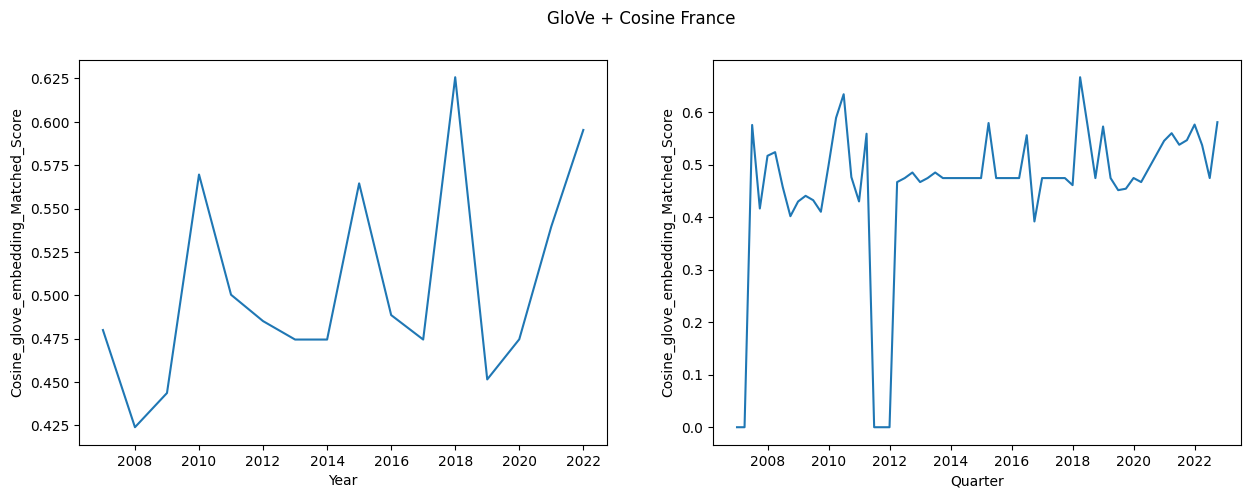

In [ ]:
France_glove_y = match_cosine_similarity(data_BdF_year_wise, data_MF_year_wise)
France_glove_q = match_cosine_similarity(data_BdF_quarter_wise, data_MF_quarter_wise)

fig = plt.figure(figsize=(15,5))
plt.subplot(121)
sns.lineplot(data=France_glove_y, x='Year', y='Cosine_glove_embedding_Matched_Score');

plt.subplot(122)
sns.lineplot(data=France_glove_q, x='Quarter', y='Cosine_glove_embedding_Matched_Score')
fig.suptitle('GloVe + Cosine France', fontsize=12);

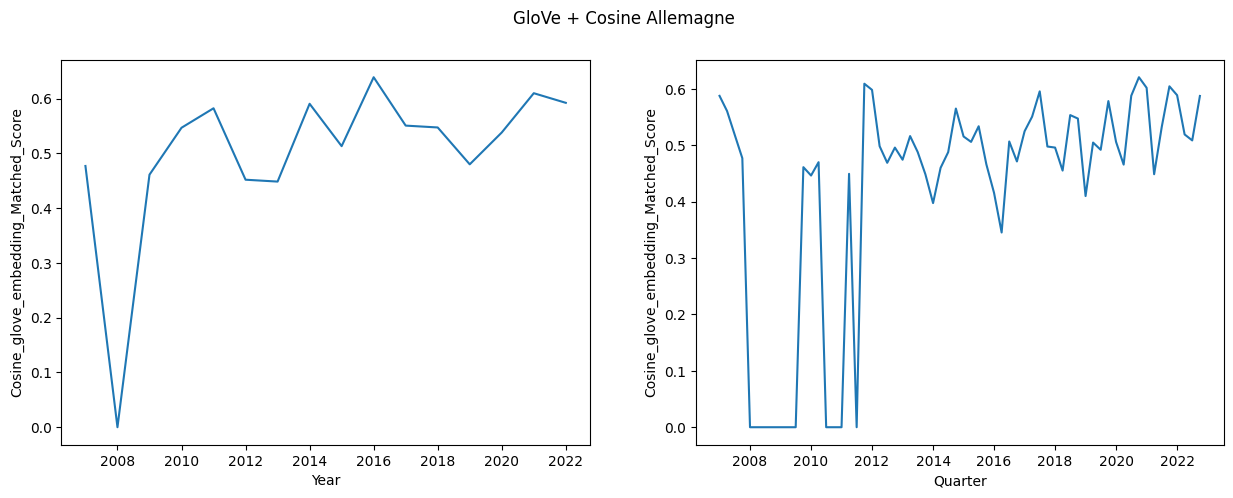

In [ ]:
Germany_glove_y = match_cosine_similarity(data_BB_year_wise, data_BFM_year_wise)
Germany_glove_q = match_cosine_similarity(data_BB_quarter_wise, data_BFM_quarter_wise)

fig = plt.figure(figsize=(15,5))
plt.subplot(121)
sns.lineplot(data=Germany_glove_y, x='Year', y='Cosine_glove_embedding_Matched_Score');

plt.subplot(122)
sns.lineplot(data=Germany_glove_q, x='Quarter', y='Cosine_glove_embedding_Matched_Score')
fig.suptitle('GloVe + Cosine Allemagne', fontsize=12);

# TF-IDF + Hierarchical Agglomerative Clustering + Centroid Based



La classification ascendante hiérarchique part d'une situation où tous les individus sont seuls dans une classe, puis sont rassemblés en classes de plus en plus grandes.
Le qualificatif « hiérarchique » vient du fait qu'elle produit une hiérarchie $H$, l'ensemble des classes à toutes les étapes de l'algorithme, qui vérifie les propriétés suivantes :
* $\Omega \in H $: au sommet de la hiérarchie, lorsqu'on groupe de manière à obtenir une seule classe, tous les individus sont regroupés ;

* $\forall \omega \in \Omega, \{\omega\} \in H$ : en bas de la hiérarchie, tous les individus $\omega$ se trouvent seuls ;

* $\forall (h,h') \in H^2, h \cap h' = \emptyset $ ou $h \subset h'$ ou $h' \subset h :$ si l’on considère deux classes du regroupement, alors soit elles n'ont pas d’individu en commun, soit l'une est incluse dans l’autre.

La classification se fait à partir d'un ensemble $\Omega$ de $n$ individus, son but est de répartir ces individus dans un certain nombre de classes.

La méthode suppose qu'on dispose d'une mesure de dissimilarité entre les individus ; dans le cas de points situés dans un espace euclidien, on peut utiliser la distance comme mesure de dissimilarité.

In [ ]:
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.spatial.distance import cdist
from scipy.cluster.hierarchy import dendrogram

import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist


def hierarchical_clustering_dendrogram(strings):
    # Création d'une vectorisation TF-IDF
    vectorizer = TfidfVectorizer()

    # Vectorisation des strings
    string_vectors = vectorizer.fit_transform(strings)

    # Application d'une classification ascendante hiérarchique
    clustering = AgglomerativeClustering(compute_full_tree=True)
    clustering.fit(string_vectors.toarray())

    # Calculer la distance entre les paires de strings
    pairwise_distances = cdist(string_vectors.toarray(), string_vectors.toarray(), metric='chebyshev')

    # Trouver l'index de la paire des strings
    string1_idx, string2_idx = np.triu_indices(len(strings), k=1)
    distances = pairwise_distances[string1_idx, string2_idx]

    return distances

In [ ]:
def agglomerative_centroid_matching(first_df, second_df):

    # Faire correspondre les valeurs et calculer la similarity
    first_df['Agglomerative_Centroid_Matched_Text'] = ''
    first_df['Agglomerative_Centroid_Matched_Score'] = ''

    for i, row in first_df.iterrows():
        string1 = row['Preprocessed_Text']

        if "Year" in second_df:
          second_df_new = second_df[second_df['Year'] == int(row['Year'])+lag_years]
        if "Quarter" in second_df:
          new_date = row['Quarter'] + relativedelta(months=lag_months)
          second_df_new = second_df[second_df['Quarter'] == new_date]

        if second_df_new.shape[0] !=0:
            score = hierarchical_clustering_dendrogram([string1, second_df_new['Preprocessed_Text'].values.flatten()[0]])
            text = second_df_new['Preprocessed_Text'].values.flatten()[0]
        else:
            score = [0]
            text = "No Text"

        first_df.at[i, 'Agglomerative_Centroid_Matched_Text'] = text
        first_df.at[i, 'Agglomerative_Centroid_Matched_Score'] = score[0]

    # Output tnouveau dataframe
    return first_df

## HAC on Data

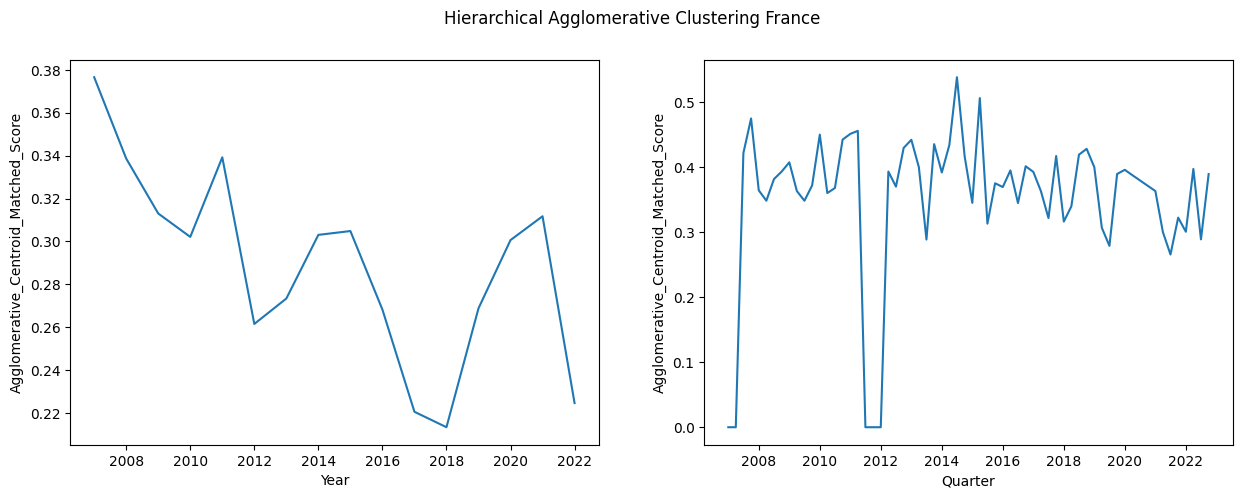

In [ ]:
France_HAC_y = agglomerative_centroid_matching(data_BdF_year_wise, data_MF_year_wise)
France_HAC_q = agglomerative_centroid_matching(data_BdF_quarter_wise, data_MF_quarter_wise)

fig = plt.figure(figsize=(15,5))
plt.subplot(121)
sns.lineplot(data=France_HAC_y, x='Year', y='Agglomerative_Centroid_Matched_Score');

plt.subplot(122)
sns.lineplot(data=France_HAC_q, x='Quarter', y='Agglomerative_Centroid_Matched_Score')
fig.suptitle('Hierarchical Agglomerative Clustering France', fontsize=12);

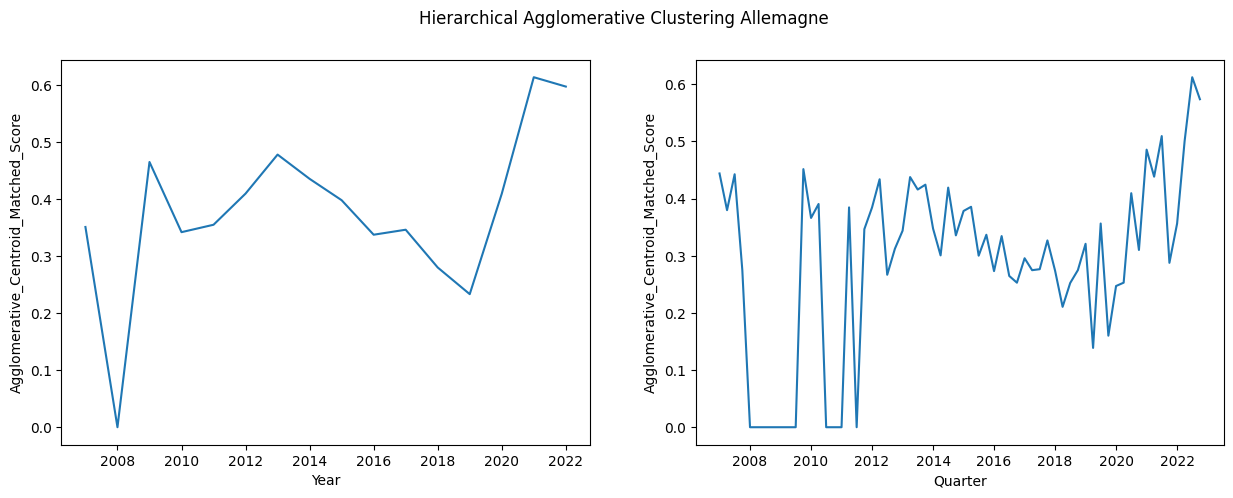

In [ ]:
Germany_HAC_y = agglomerative_centroid_matching(data_BB_year_wise, data_BFM_year_wise)
Germany_HAC_q = agglomerative_centroid_matching(data_BB_quarter_wise, data_BFM_quarter_wise)

fig = plt.figure(figsize=(15,5))
plt.subplot(121)
sns.lineplot(data=Germany_HAC_y, x='Year', y='Agglomerative_Centroid_Matched_Score');

plt.subplot(122)
sns.lineplot(data=Germany_HAC_q, x='Quarter', y='Agglomerative_Centroid_Matched_Score')
fig.suptitle('Hierarchical Agglomerative Clustering Allemagne', fontsize=12);

# Latent Semantic Indexing (LSI)

L'analyse sémantique latente est un procédé de traitement des langues naturelles qui permet d'établir des relations entre un ensemble de documents et les termes qu'ils contiennent, en construisant des « concepts » liés aux documents et aux termes.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity

def lsi_match(string1, string2):
    # Pré-traitement des strings
    preprocessed_strings = [string1, string2]

    # Creation d'une matrice en utilisant la pondération TF-IDF
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(preprocessed_strings)

    # Application de Latent Semantic Indexing (LSI) en utilisant Truncated SVD
    try:
        lsi_model = TruncatedSVD(n_components=600)  # Choisir le nombres de concepts
        lsi_matrix = lsi_model.fit_transform(tfidf_matrix)
    except:
        total = " ".join(preprocessed_strings)
        total = list(set(total.split(" ")))
        lsi_model = TruncatedSVD(n_components=len(total))  # Choisir le nombres de concepts
        lsi_matrix = lsi_model.fit_transform(tfidf_matrix)

    # Calculer la cosine similarity entre les representation LSI des strings
    similarity = cosine_similarity([lsi_matrix[0]], [lsi_matrix[1]])[0][0]

    return similarity

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity

def lsi_matching(first_df, second_df):

    # Faire correspondre les valeurs et calculer la similarity
    first_df['LSI_Matched_Text'] = ''
    first_df['LSI_Matched_Score'] = ''

    for i, row in first_df.iterrows():
        string1 = row['Preprocessed_Text']

        if 'Year' in second_df:
          second_df_new = second_df[second_df['Year'] == int(row['Year'])+lag_years]
        if 'Quarter' in second_df:
          new_date = row['Quarter'] + relativedelta(months=lag_months)
          second_df_new = second_df[second_df['Quarter'] == new_date]

        if second_df_new.shape[0] !=0:
            score = lsi_match(string1, second_df_new['Preprocessed_Text'].values.flatten()[0])
            #print(string1, second_df_new['Preprocessed_Text'].values.flatten()[0], score)
            text = second_df_new['Preprocessed_Text'].values.flatten()[0]
        else:
            score = 0
            text = "No Text"

        first_df.at[i, 'LSI_Matched_Text'] = text
        first_df.at[i, 'LSI_Matched_Score'] = score

    # Output nouveau dataframe
    return first_df

## LSI on Data

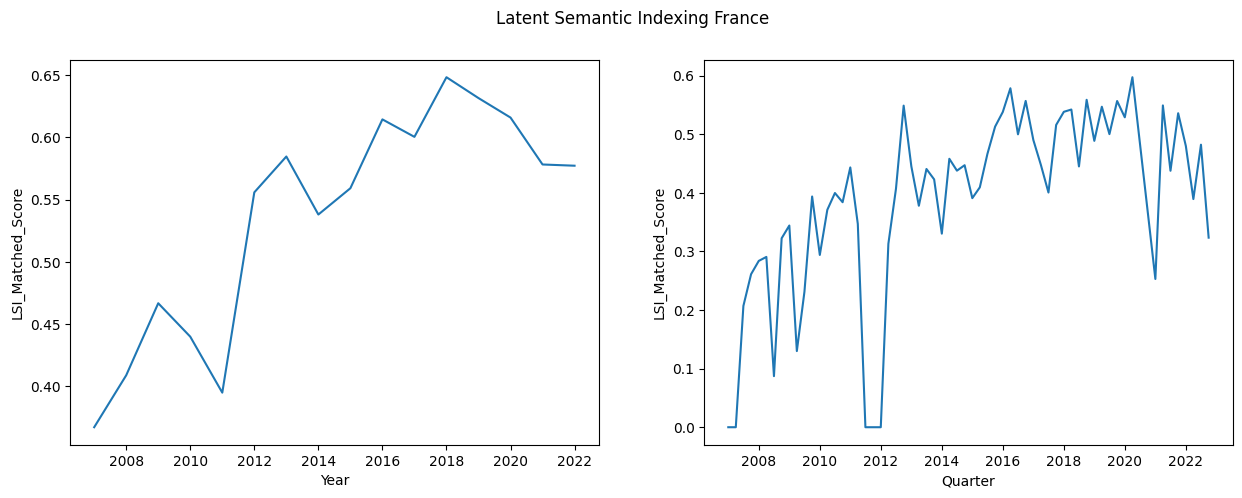

In [ ]:
France_LSI_y = lsi_matching(data_BdF_year_wise, data_MF_year_wise)
France_LSI_q = lsi_matching(data_BdF_quarter_wise, data_MF_quarter_wise)

fig = plt.figure(figsize=(15,5))
plt.subplot(121)
sns.lineplot(data=France_LSI_y, x='Year', y='LSI_Matched_Score');

plt.subplot(122)
sns.lineplot(data=France_LSI_q, x='Quarter', y='LSI_Matched_Score')
fig.suptitle('Latent Semantic Indexing France', fontsize=12);

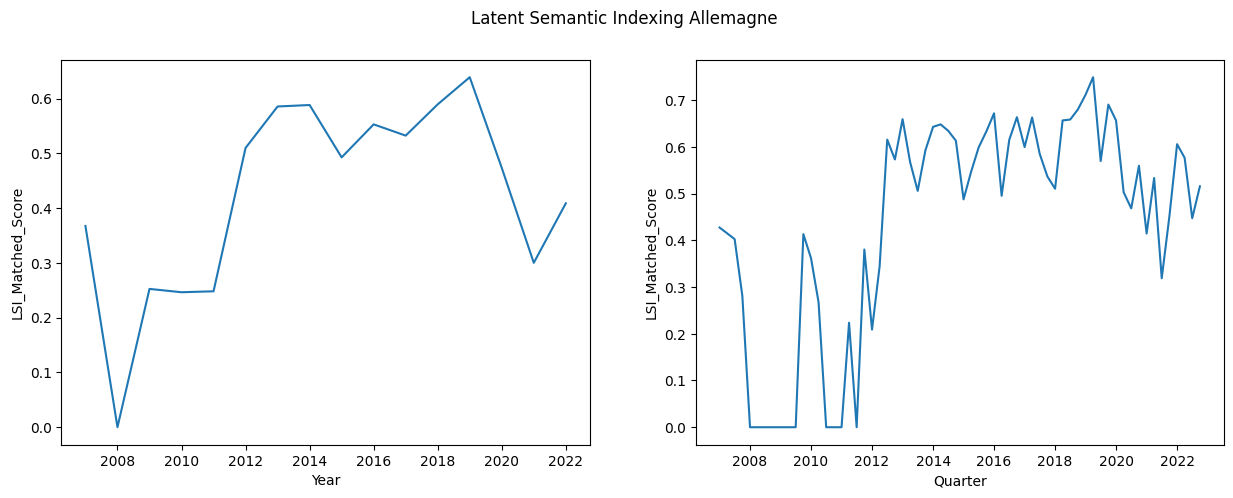

In [ ]:
Germany_LSI_y = lsi_matching(data_BB_year_wise, data_BFM_year_wise)
Germany_LSI_q = lsi_matching(data_BB_quarter_wise, data_BFM_quarter_wise)

fig = plt.figure(figsize=(15,5))
plt.subplot(121)
sns.lineplot(data=Germany_LSI_y, x='Year', y='LSI_Matched_Score');

plt.subplot(122)
sns.lineplot(data=Germany_LSI_q, x='Quarter', y='LSI_Matched_Score')
fig.suptitle('Latent Semantic Indexing Allemagne', fontsize=12);


# NMF + Jensen-Shannon distance

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import NMF
from scipy.spatial import distance
import numpy as np

def nmf_match(string1, string2, num_topics=30):
    # Preprocess the strings (you can customize this based on your requirements)
    preprocessed_strings = [string1, string2]

    # Create a document-term matrix using CountVectorizer
    vectorizer = CountVectorizer()
    dtm = vectorizer.fit_transform(preprocessed_strings)

    # Apply Latent Dirichlet Allocation (LDA)
    nmf_model = NMF(n_components=num_topics)
    nmf_model.fit(dtm)

    # Get topic distributions for the strings
    string1_topics = nmf_model.transform(vectorizer.transform([string1]))
    string2_topics = nmf_model.transform(vectorizer.transform([string2]))

    # Calculate Jensen-Shannon distance between the topic distributions
    js_distance = distance.jensenshannon(string1_topics.flatten(), string2_topics.flatten())

    return js_distance

In [ ]:
import pandas as pd
import numpy as np
import nltk

def nmf_matching(first_df, second_df, num_topics=30):

    # Match values and calculate similarity
    first_df['Jensen_Shannon_Matched_Text'] = ''
    first_df['Jensen_Shannon_Matched_Score'] = ''

    for i, row in first_df.iterrows():
      string1 = row['Processed TEXT']

      if 'Year' in second_df:
        second_df_new = second_df[second_df['Year'] == int(row['Year'])+lag_years]
      if 'Quarter' in second_df:
        new_date = row['Quarter'] + relativedelta(months=lag_months)
        second_df_new = second_df[second_df['Quarter'] == new_date]

      if second_df_new.shape[0] !=0:
        score = nmf_match(string1, second_df_new['Processed TEXT'].values.flatten()[0], num_topics=num_topics)
        text = second_df_new['Processed TEXT'].values.flatten()[0]
      else:
        score = 0
        text = "No Text"
      first_df.at[i, 'Jensen_Shannon_Matched_Text'] = text
      first_df.at[i, 'Jensen_Shannon_Matched_Score'] = score

    # Output the resulting dataframe
    return first_df

## NMF on Data

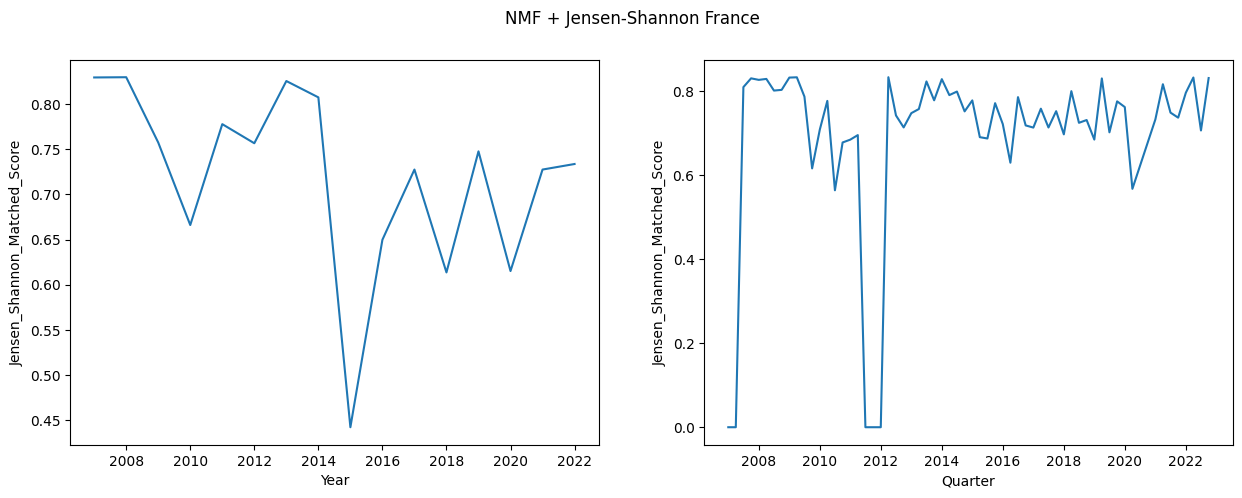

In [ ]:
France_NMF_y = nmf_matching(data_BdF_year_wise, data_MF_year_wise)
France_NMF_q = nmf_matching(data_BdF_quarter_wise, data_MF_quarter_wise)

fig = plt.figure(figsize=(15,5))
plt.subplot(121)
sns.lineplot(data=France_NMF_y, x='Year', y='Jensen_Shannon_Matched_Score');

plt.subplot(122)
sns.lineplot(data=France_NMF_q, x='Quarter', y='Jensen_Shannon_Matched_Score')
fig.suptitle('NMF + Jensen-Shannon France', fontsize=12);

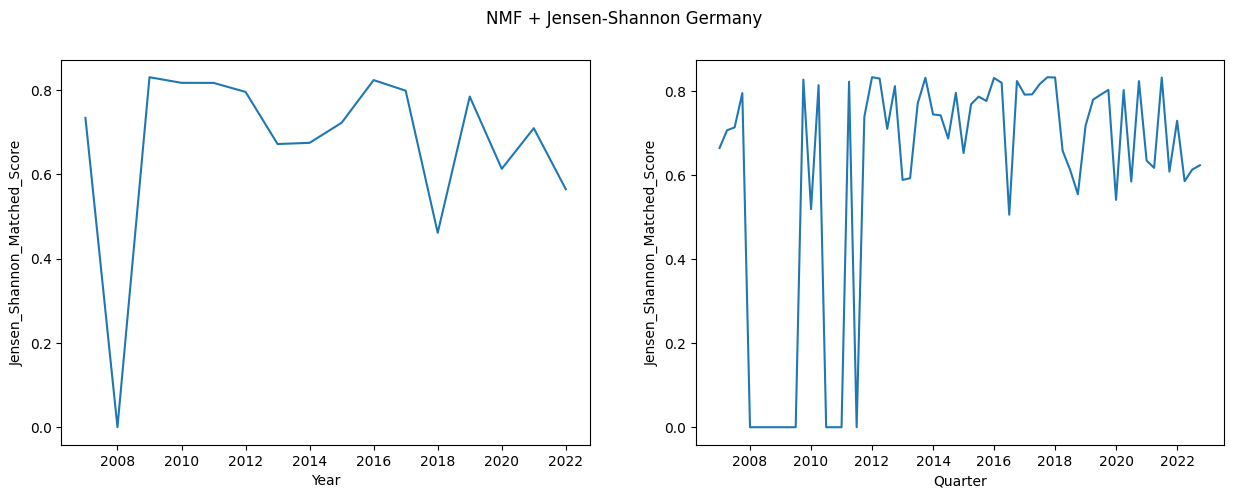

In [ ]:
Germany_NMF_y = nmf_matching(data_BB_year_wise, data_BFM_year_wise)
Germany_NMF_q = nmf_matching(data_BB_quarter_wise, data_BFM_quarter_wise)

fig = plt.figure(figsize=(15,5))
plt.subplot(121)
sns.lineplot(data=Germany_NMF_y, x='Year', y='Jensen_Shannon_Matched_Score');

plt.subplot(122)
sns.lineplot(data=Germany_NMF_q, x='Quarter', y='Jensen_Shannon_Matched_Score')
fig.suptitle('NMF + Jensen-Shannon Germany', fontsize=12);

# Aggregated Similiarty Scores

In [ ]:
france_agg_y = pd.DataFrame([France_jaccard_y['Jaccard_Matched_score'],
                    France_kmeans_y['KMeans_Embedding_Matched_Score'],
                    #France_glove_y['Cosine_glove_embedding_Matched_Score'],
                    France_HAC_y['Agglomerative_Centroid_Matched_Score'],
                    France_LSI_y['LSI_Matched_Score'],
                    #France_NMF_y['Jensen_Shannon_Matched_Score']]
                    ]).transpose()
france_agg_q = pd.DataFrame([
                    France_jaccard_q['Jaccard_Matched_score'],
                    France_kmeans_q['KMeans_Embedding_Matched_Score'],
                    #France_glove_q['Cosine_glove_embedding_Matched_Score'],
                    France_HAC_q['Agglomerative_Centroid_Matched_Score'],
                    France_LSI_q['LSI_Matched_Score'],
                    #France_NMF_q['Jensen_Shannon_Matched_Score']
                    ]).transpose()

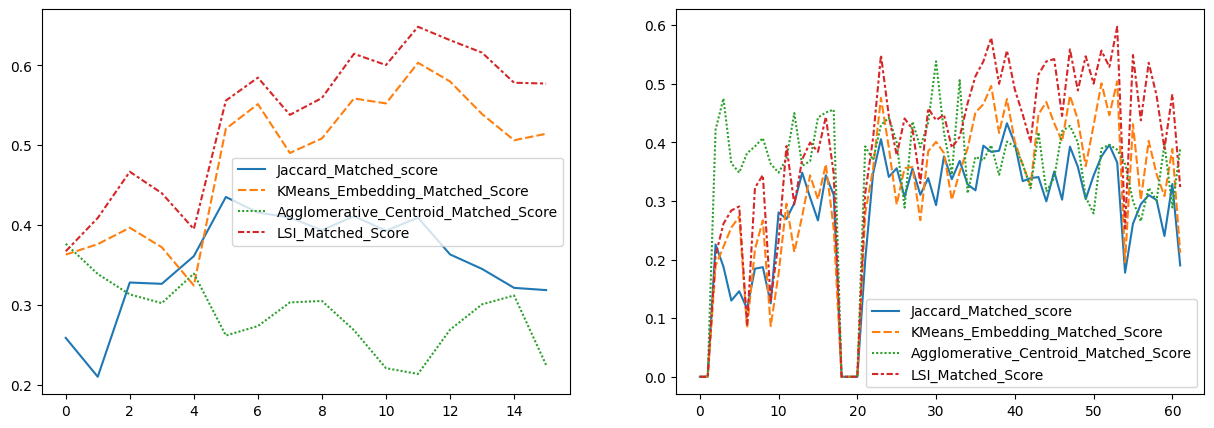

In [ ]:
fig = plt.figure(figsize=(15,5))
plt.subplot(121)
sns.lineplot(france_agg_y)
plt.subplot(122)
sns.lineplot(france_agg_q);

In [ ]:
france_agg_q = france_agg_q.set_index(France_LSI_q['Quarter'])

#Remplacer valeurs manquants avec le median
for col in france_agg_q.columns:
    val = france_agg_q[col].median()
    france_agg_q[col] = france_agg_q[col].replace(0, val)

france_agg_q['mean_score'] = france_agg_q.mean(axis=1)

france_agg_y = france_agg_y.set_index(France_LSI_y['Year'])

#Remplacer valeurs manquants avec le median
for col in france_agg_y.columns:
    val = france_agg_y[col].median()
    france_agg_y[col] = france_agg_y[col].replace(0, val)

france_agg_y['mean_score'] = france_agg_y.mean(axis=1)

In [ ]:
germany_agg_y = pd.DataFrame([
                    Germany_jaccard_y['Jaccard_Matched_score'],
                    Germany_kmeans_y['KMeans_Embedding_Matched_Score'],
                    #Germany_glove_y['Cosine_glove_embedding_Matched_Score'],
                    Germany_HAC_y['Agglomerative_Centroid_Matched_Score'],
                    Germany_LSI_y['LSI_Matched_Score'],
                    #Germany_NMF_y['Jensen_Shannon_Matched_Score']
                    ]).transpose()

germany_agg_q = pd.DataFrame([
                    Germany_jaccard_q['Jaccard_Matched_score'],
                    Germany_kmeans_q['KMeans_Embedding_Matched_Score'],
                    #Germany_glove_q['Cosine_glove_embedding_Matched_Score'],
                    Germany_HAC_q['Agglomerative_Centroid_Matched_Score'],
                    Germany_LSI_q['LSI_Matched_Score'],
                    #Germany_NMF_q['Jensen_Shannon_Matched_Score']
                    ]).transpose()

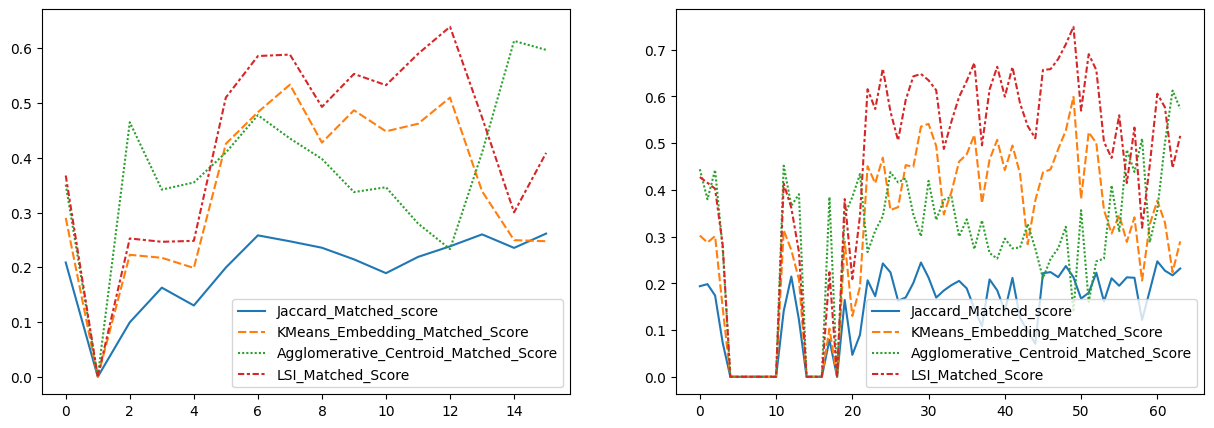

In [ ]:
fig = plt.figure(figsize=(15,5))
plt.subplot(121)
sns.lineplot(germany_agg_y)
plt.subplot(122)
sns.lineplot(germany_agg_q);

In [ ]:
germany_agg_q = germany_agg_q.set_index(Germany_LSI_q['Quarter'])

#Remplacer valeurs manquants avec le median
for col in germany_agg_q.columns:
    val = germany_agg_q[col].median()
    germany_agg_q[col] = germany_agg_q[col].replace(0, val)

germany_agg_q['mean_score'] = germany_agg_q.mean(axis=1)

germany_agg_y = germany_agg_y.set_index(France_LSI_y['Year'])

#Remplacer valeurs manquants avec le median
for col in germany_agg_y.columns:
    val = germany_agg_y[col].median()
    germany_agg_y[col] = germany_agg_y[col].replace(0, val)

germany_agg_y['mean_score'] = germany_agg_y.mean(axis=1)

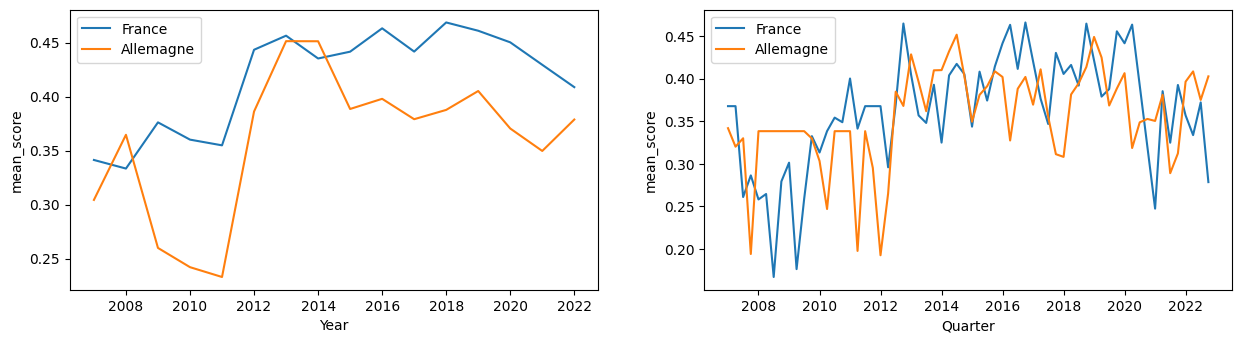

In [ ]:
fig = plt.figure(figsize=(15,8))
plt.subplot(221)
sns.lineplot(france_agg_y['mean_score'], label='France')
plt.subplot(221)
sns.lineplot(germany_agg_y['mean_score'], label='Allemagne')
plt.subplot(222)
sns.lineplot(france_agg_q['mean_score'], label='France')
plt.subplot(222)
sns.lineplot(germany_agg_q['mean_score'], label='Allemagne');

In [ ]:
val_agg_f = france_agg_q['mean_score'].rolling(min_periods=1, center=True, window=8).mean()
val_agg_g = germany_agg_q['mean_score'].rolling(min_periods=1, center=True, window=8).mean()
val_agg_f.plot()
val_agg_g.plot()

In [ ]:
france_agg_y.to_csv(path+'/Data/Intermediate_Data/france_agg_y.csv')
germany_agg_y.to_csv(path+'/Data/Intermediate_Data/germany_agg_y.csv')

In [ ]:
france_agg_q.to_csv(path+'/Data/Intermediate_Data/france_agg_q_lag.csv')
germany_agg_q.to_csv(path+'/Data/Intermediate_Data/germany_agg_q_lag.csv')

# Word Mover Distance

Check why this does not work well? Probably texts too long... But don't know

In [ ]:
!pip install POT
!pip install fasttext

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import gensim.downloader as api

In [ ]:
from gensim import models
import gensim

In [ ]:
from nltk.corpus import stopwords
import nltk
from nltk import download

nltk.download('punkt')
# Download stopwords from NLTK
nltk.download('stopwords')
stop_words_fr = stopwords.words('french')
stop_words_de = stopwords.words('german')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
import fasttext
import fasttext.util

In [ ]:
fasttext.util.download_model('fr', if_exists='ignore')

'cc.fr.300.bin'

In [ ]:
fasttext.util.download_model('de', if_exists='ignore')

'cc.de.300.bin'

In [ ]:
# Import French Word2Vec model
#model_name_fr = gensim.models.fasttext.load_facebook_model('cc.fr.300.bin')
model_name_de = models.fasttext.load_facebook_model('cc.de.300.bin')

#def preprocess_fr(sentence):
#    return [w for w in sentence.lower().split() if w not in stop_words_fr]

def preprocess_de(sentence):
    return [w for w in sentence.lower().split() if w not in stop_words_de]

In [ ]:
def wmd_match(first_df, second_df):
    # Match values and calculate similarity
    first_df['WMD_Matched_Text'] = ''
    first_df['WMD_Matched_Score'] = ''

    for i, row in first_df.iterrows():
        query_text = row['Preprocessed_Text']
        query_text = preprocess_de(query_text)  # Apply preprocessing to query_text
        similarity_scores = []

        if 'Year' in second_df:
            second_df_new = second_df[second_df['Year'] == int(row['Year']) + lag_years]
        if 'Quarter' in second_df:
            new_date = row['Quarter'] + relativedelta(months=lag_months)
            second_df_new = second_df[second_df['Quarter'] == new_date]

        for j, match_row in second_df_new.iterrows():
            match_text = match_row['Preprocessed_Text']
            match_text = preprocess_de(match_text)  # Apply preprocessing to match_text
            similarity = model_name_de.wv.wmdistance(query_text, match_text)
            similarity_scores.append(similarity)

        if len(similarity_scores) == 0:
            similarity_scores = [0]
        best_match_index = similarity_scores.index(max(similarity_scores))
        best_match = second_df_new['Preprocessed_Text']
        best_score = similarity_scores[best_match_index]  # Invert the distance to get the similarity score

        first_df.at[i, 'WMD_Matched_Text'] = best_match
        first_df.at[i, 'WMD_Matched_Score'] = best_score

    # Output the resulting dataframe
    return first_df

## WMD on Data

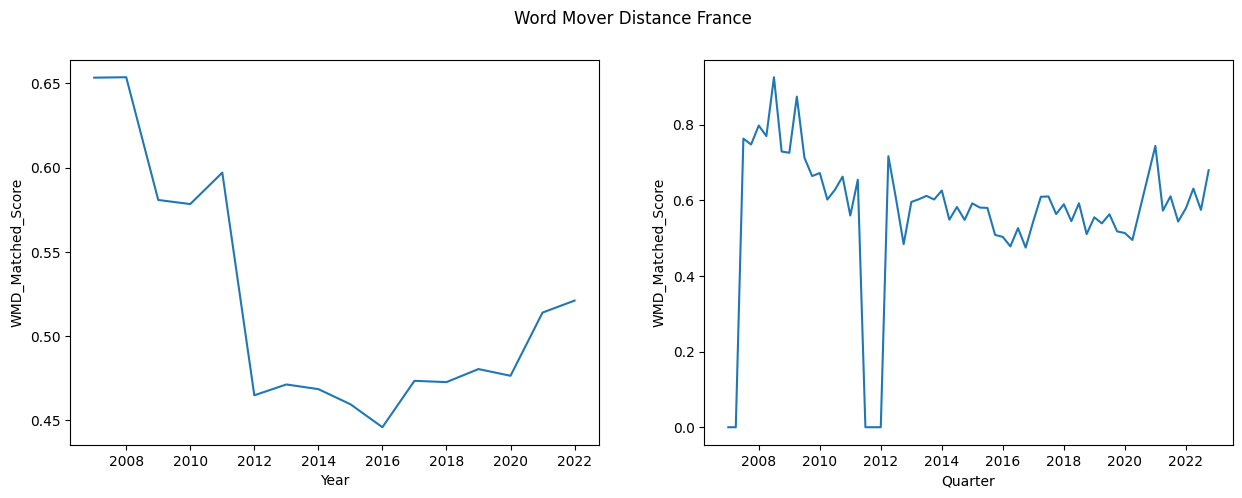

In [ ]:
France_Word_Mover_y = wmd_match(data_BdF_year_wise, data_MF_year_wise)
France_Word_Mover_q = wmd_match(data_BdF_quarter_wise, data_MF_quarter_wise)

fig = plt.figure(figsize=(15,5))
plt.subplot(121)
sns.lineplot(data=France_Word_Mover_y, x='Year', y='WMD_Matched_Score');

plt.subplot(122)
sns.lineplot(data=France_Word_Mover_q, x='Quarter', y='WMD_Matched_Score')
fig.suptitle('Word Mover Distance France', fontsize=12);

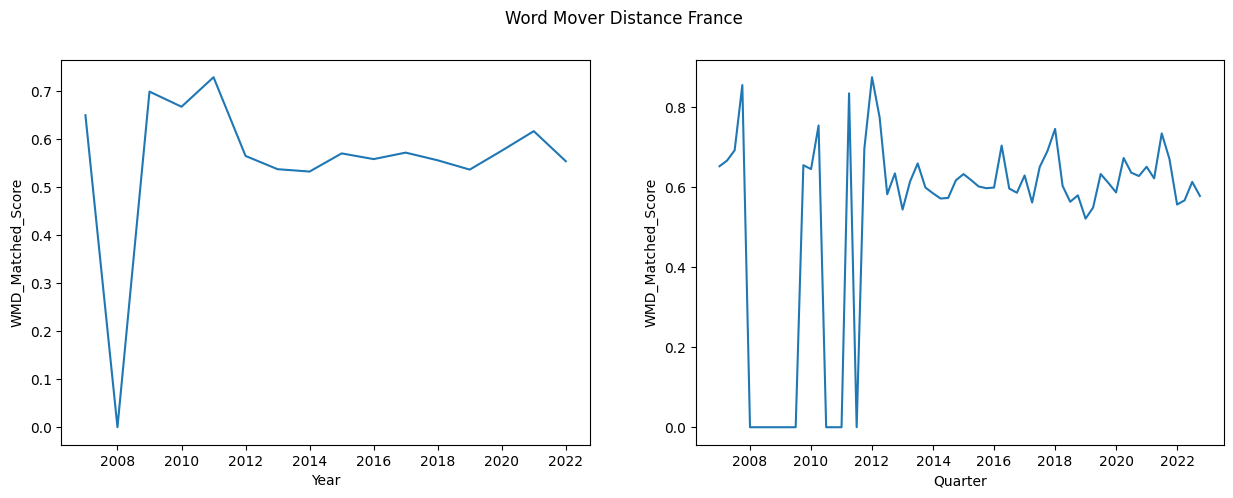

In [ ]:
Germany_Word_Mover_y = wmd_match(data_BB_year_wise, data_BFM_year_wise)
Germany_Word_Mover_q = wmd_match(data_BB_quarter_wise, data_BFM_quarter_wise)

fig = plt.figure(figsize=(15,5))
plt.subplot(121)
sns.lineplot(data=Germany_Word_Mover_y, x='Year', y='WMD_Matched_Score');

plt.subplot(122)
sns.lineplot(data=Germany_Word_Mover_q, x='Quarter', y='WMD_Matched_Score')
fig.suptitle('Word Mover Distance France', fontsize=12);

# Sentence Transformers (SBERT)

In [15]:
!pip install sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 53.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 34.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 73.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 77.4 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125923 sha256=a4f36db3cd19e1162ad4841047bd72e1947cf9b41a3313b6f08ee73e7ce51780
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence-transformers


In [16]:
from sentence_transformers import SentenceTransformer
from scipy.spatial.distance import cosine

# Load pre-trained sentence encoder model for French
model = SentenceTransformer('distiluse-base-multilingual-cased-v2')

def encode_sentence(sentence):
    # Encode the sentence into a fixed-dimensional vector
    sentence_embedding = model.encode([sentence])[0]
    return sentence_embedding

def cosine_similarity(sentence1, sentence2):
    # Encode the sentences into vectors
    embedding1 = encode_sentence(sentence1)
    embedding2 = encode_sentence(sentence2)

    # Calculate the cosine similarity between the embeddings
    similarity = 1 - cosine(embedding1, embedding2)
    return similarity

def process_in_batches(sentences, batch_size):
    num_sentences = len(sentences)
    num_batches = int((num_sentences + batch_size - 1) / batch_size)
    batches = [sentences[i * batch_size : (i + 1) * batch_size] for i in range(num_batches)]
    return batches

def process_in_chunks(sentences, chunk_size):
    chunks = [sentences[i * chunk_size : (i + 1) * chunk_size] for i in range((len(sentences) + chunk_size - 1) // chunk_size)]
    return [pd.DataFrame(chunk, columns=['Processed_text_sentences']) for chunk in chunks]

In [100]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

# Load pre-trained sentence encoder model for French
model = SentenceTransformer('distiluse-base-multilingual-cased-v2')

def encode_sentence(sentence):
    # Encode the sentence into a fixed-dimensional vector
    sentence_embedding = model.encode([sentence])[0]
    return np.array(sentence_embedding)

def sentence_encoder_matching(first_df, second_df):
    # Match values and calculate similarity
    first_df['Sentence_Encoder_Matched_Text'] = ''
    first_df['Sentence_Encoder_Matched_Score'] = ''

    for i, row in first_df.iterrows():
        try:
            if 'Processed_text_sentences' in row:
                sentence = str(row['Processed_text_sentences'])
            else:
                sentence = str(row['Processed_text_sentences'])
        except KeyError:
            sentence = ''

        sentence_pair = [sentence, sentence]
        string1 = encode_sentence(sentence_pair[0])

        if 'Year' in second_df.columns:
            second_df_new = second_df[second_df['Year'] == int(row['Year']) + 0]
        elif 'Quarter' in second_df.columns:
            new_date = row['Quarter'] + pd.DateOffset(months=0)
            second_df_new = second_df[second_df['Quarter'] == new_date]
        else:
            second_df_new = pd.DataFrame()

        if not second_df_new.empty:
            try:
                if 'Processed_text_sentences' in second_df_new.columns:
                    text = str(second_df_new['Processed_text_sentences'].iloc[0])
                else:
                    text = str(second_df_new['Processed_text_sentences'].iloc[0])
            except KeyError:
                text = 'No Text'
            sentence_pair = [text, text]
            string2 = encode_sentence(sentence_pair[0])
            score = cosine_similarity(string1.reshape(1, -1), string2.reshape(1, -1))[0][0]
        else:
            score = 0
            text = 'No Text'

        first_df.at[i, 'Sentence_Encoder_Matched_Text'] = text
        first_df.at[i, 'Sentence_Encoder_Matched_Score'] = score

    # Output the resulting dataframe
    return first_df

## SBERT on Data

CPU times: user 31.4 s, sys: 404 ms, total: 31.8 s
Wall time: 31.3 s


Text(0.5, 0.98, 'Sentence Encoder Indexing France')

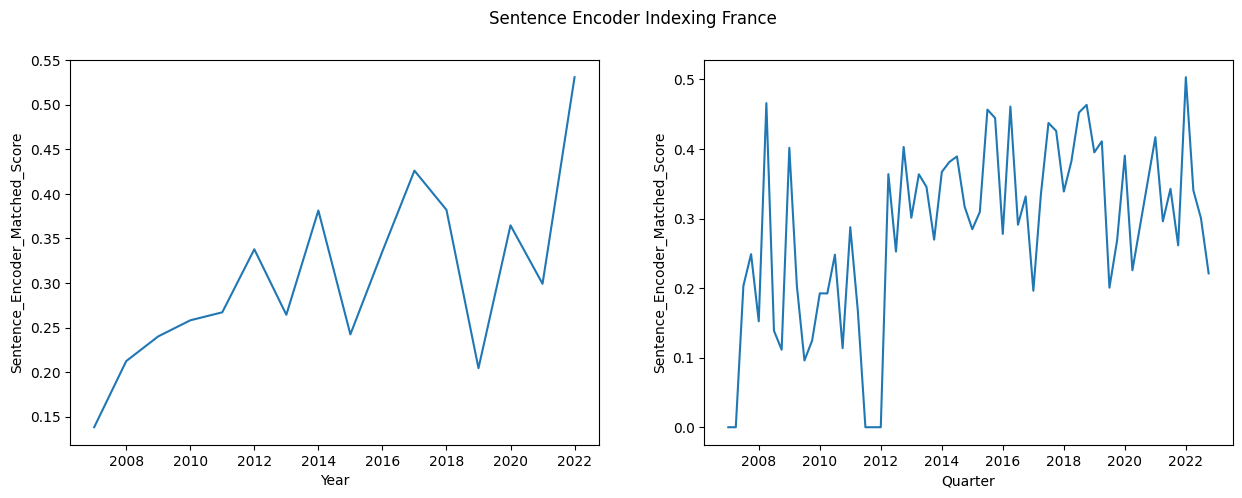

In [101]:
%%time
France_Sentence_Encoder_y = sentence_encoder_matching(data_BdF_year_wise, data_MF_year_wise)
France_Sentence_Encoder_q = sentence_encoder_matching(data_BdF_quarter_wise, data_MF_quarter_wise)

fig = plt.figure(figsize=(15,5))
plt.subplot(121)
sns.lineplot(data=France_Sentence_Encoder_y, x='Year', y='Sentence_Encoder_Matched_Score');

plt.subplot(122)
sns.lineplot(data=France_Sentence_Encoder_q, x='Quarter', y='Sentence_Encoder_Matched_Score')
fig.suptitle('Sentence Encoder Indexing France', fontsize=12);

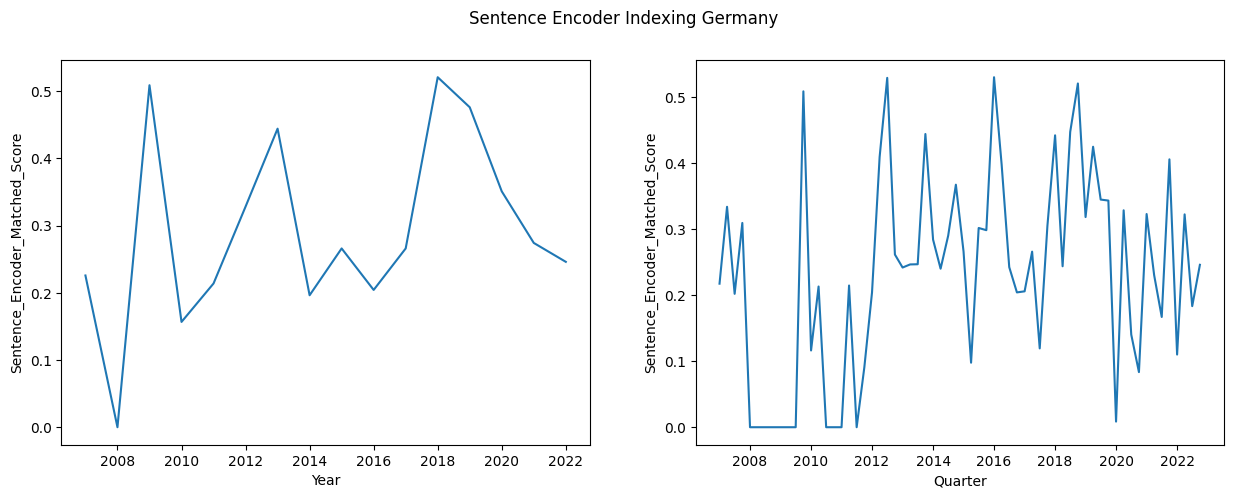

In [102]:
Germany_Sentence_Encoder_y = sentence_encoder_matching(data_BB_year_wise, data_BFM_year_wise)
Germany_Sentence_Encoder_q = sentence_encoder_matching(data_BB_quarter_wise, data_BFM_quarter_wise)

fig = plt.figure(figsize=(15,5))
plt.subplot(121)
sns.lineplot(data=Germany_Sentence_Encoder_y, x='Year', y='Sentence_Encoder_Matched_Score');

plt.subplot(122)
sns.lineplot(data=Germany_Sentence_Encoder_q, x='Quarter', y='Sentence_Encoder_Matched_Score')
fig.suptitle('Sentence Encoder Indexing Germany', fontsize=12);

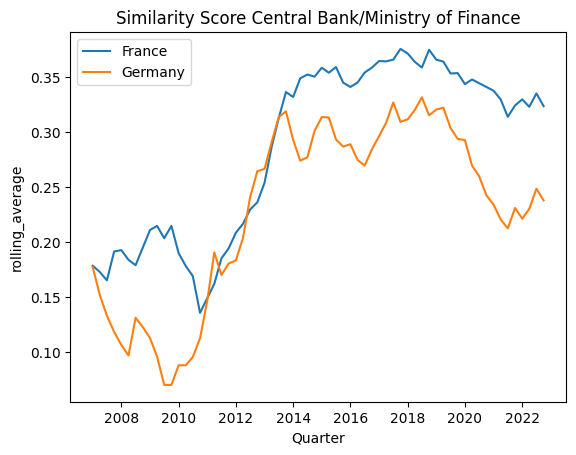

In [103]:
#France_Sentence_Encoder_q['Sentence_Encoder_Matched_Score']
France_Sentence_Encoder_q['rolling_average'] = France_Sentence_Encoder_q['Sentence_Encoder_Matched_Score'].rolling(min_periods=3, center=True, window=12).mean()
Germany_Sentence_Encoder_q['rolling_average'] = Germany_Sentence_Encoder_q['Sentence_Encoder_Matched_Score'].rolling(min_periods=3, center=True, window=12).mean()
fra = sns.lineplot(data=France_Sentence_Encoder_q, x='Quarter', y='rolling_average', label='France')
ger = sns.lineplot(data=Germany_Sentence_Encoder_q, x='Quarter', y='rolling_average', label='Germany')

plt.legend()
plt.title('Similarity Score Central Bank/Ministry of Finance')
plt.show()

In [104]:
France_Sentence_Encoder_q["Sentence_Encoder_Matched_Score"] = France_Sentence_Encoder_q["Sentence_Encoder_Matched_Score"].where(France_Sentence_Encoder_q["Sentence_Encoder_Matched_Score"] != 0, France_Sentence_Encoder_q['rolling_average'] )

Germany_Sentence_Encoder_q["Sentence_Encoder_Matched_Score"] = Germany_Sentence_Encoder_q["Sentence_Encoder_Matched_Score"].where(Germany_Sentence_Encoder_q["Sentence_Encoder_Matched_Score"] != 0, Germany_Sentence_Encoder_q['rolling_average'])

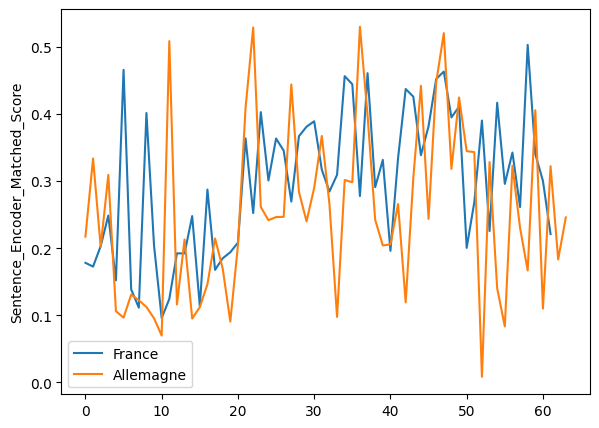

In [105]:
fig = plt.figure(figsize=(15,5))
plt.subplot(121)
sns.lineplot(France_Sentence_Encoder_q['Sentence_Encoder_Matched_Score'], label='France')
plt.subplot(121)
sns.lineplot(Germany_Sentence_Encoder_q['Sentence_Encoder_Matched_Score'], label='Allemagne');

In [ ]:
France_Sentence_Encoder_q["Sentence_Encoder_Matched_Score"].to_csv(path+'/Data/Intermediate_Data/france_st_q2.csv')
Germany_Sentence_Encoder_q["Sentence_Encoder_Matched_Score"].to_csv(path+'/Data/Intermediate_Data/germany_st_q2.csv')

## Intra similarity

CPU times: user 30.3 s, sys: 278 ms, total: 30.6 s
Wall time: 30 s


Text(0.5, 0.98, 'Sentence Encoder Intra MF et BdF')

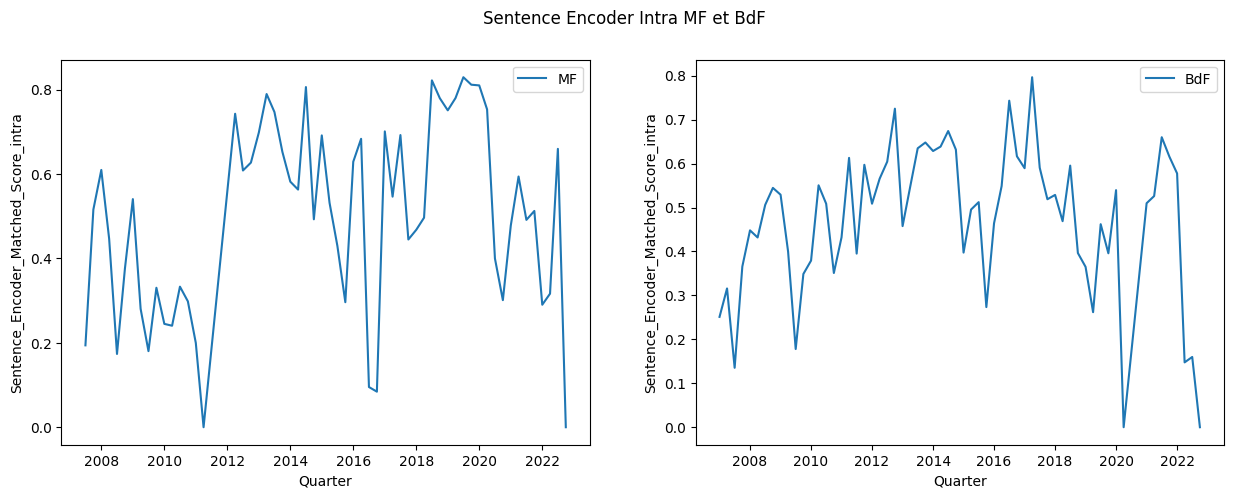

In [87]:
%%time
France_intra_qMF = sentence_encoder_matching(data_MF_quarter_wise, data_MF_quarter_wise)
France_intra_qBdF = sentence_encoder_matching(data_BdF_quarter_wise, data_BdF_quarter_wise)

fig = plt.figure(figsize=(15,5))
plt.subplot(121)
sns.lineplot(data=France_intra_qMF, x='Quarter', y='Sentence_Encoder_Matched_Score_intra', label='MF');

plt.subplot(122)
sns.lineplot(data=France_intra_qBdF, x='Quarter', y='Sentence_Encoder_Matched_Score_intra', label='BdF')
fig.suptitle('Sentence Encoder Intra MF et BdF', fontsize=12);

CPU times: user 34.4 s, sys: 245 ms, total: 34.6 s
Wall time: 34.1 s


Text(0.5, 0.98, 'Sentence Encoder Intra BFM et BB')

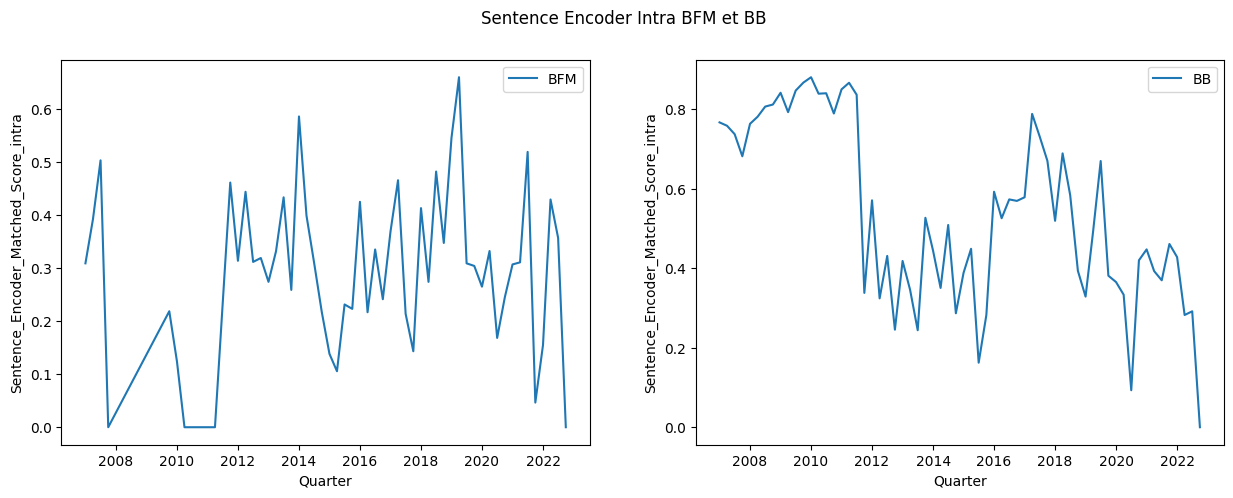

In [89]:
%%time
Germany_intra_qBFM = sentence_encoder_matching(data_BFM_quarter_wise, data_BFM_quarter_wise)
Germany_intra_qBB = sentence_encoder_matching(data_BB_quarter_wise, data_BB_quarter_wise)

fig = plt.figure(figsize=(15,5))
plt.subplot(121)
sns.lineplot(data=Germany_intra_qBFM, x='Quarter', y='Sentence_Encoder_Matched_Score_intra', label='BFM');

plt.subplot(122)
sns.lineplot(data=Germany_intra_qBB, x='Quarter', y='Sentence_Encoder_Matched_Score_intra', label='BB')
fig.suptitle('Sentence Encoder Intra BFM et BB', fontsize=12);

### Comparer inter et intra similarity

Vérifier si les changements de similarité sont corrélés entre les

In [141]:
France_Sentence_Encoder_q['score_num_en_q'] = pd.to_numeric(France_Sentence_Encoder_q['Sentence_Encoder_Matched_Score'])
France_intra_qMF['score_num'] = pd.to_numeric(France_intra_qMF['Sentence_Encoder_Matched_Score_intra'])
France_intra_qBdF['score_num'] = pd.to_numeric(France_intra_qBdF['Sentence_Encoder_Matched_Score_intra'])

# Calculate the correlation coefficients
corr_q_vs_qMF = France_Sentence_Encoder_q['score_num_en_q'].corr(France_intra_qMF['score_num'])
corr_q_vs_qBdF = France_Sentence_Encoder_q['score_num_en_q'].corr(France_intra_qBdF['score_num'])

# Print the correlation coefficients
print("Correlation entre Similarity Score (inter) et Similarity Score (intra) MF:", corr_q_vs_qMF)
print("Correlation entre Similarity Score (inter) et Similarity Score (intra) BdF:", corr_q_vs_qBdF)

Correlation entre Similarity Score (inter) et Similarity Score (intra) MF: 0.26835413030668226
Correlation entre Similarity Score (inter) et Similarity Score (intra) BdF: 0.2877503612433009


In [143]:
Germany_Sentence_Encoder_q['score_num_en_q'] = pd.to_numeric(Germany_Sentence_Encoder_q['Sentence_Encoder_Matched_Score'])
Germany_intra_qBFM['score_num'] = pd.to_numeric(Germany_intra_qBFM['Sentence_Encoder_Matched_Score_intra'])
Germany_intra_qBB['score_num'] = pd.to_numeric(Germany_intra_qBB['Sentence_Encoder_Matched_Score_intra'])

# Calculate the correlation coefficients
corr_q_vs_qBFM = Germany_Sentence_Encoder_q['score_num_en_q'].corr(Germany_intra_qBFM['score_num'])
corr_q_vs_qBB = Germany_Sentence_Encoder_q['score_num_en_q'].corr(Germany_intra_qBB['score_num'])

# Print the correlation coefficients
print("Correlation entre Similarity Score (inter) et Similarity Score (intra) BFB:", corr_q_vs_qBFM)
print("Correlation entre Similarity Score (inter) et Similarity Score (intra) BB:", corr_q_vs_qBB)

Correlation entre Similarity Score (inter) et Similarity Score (intra) BFB: 0.04809517046416746
Correlation entre Similarity Score (inter) et Similarity Score (intra) BB: -0.23975185685808617


Il n'y a pas de correlation significative entre les données intra et inter.

# Sentence Transformers (tests)

- sent to vec, not word to vec
- check similarity bank/bank and gov/gov (for robustness) - Maybe use this !

In [ ]:
pip install -U sentence-transformers

In [ ]:
from sentence_transformers import SentenceTransformer , util

In [ ]:
# télécharger 2 modèles de transformeurs :

#model1 = SentenceTransformer("sentence-transformers/all-mpnet-base-v2")

model2 = SentenceTransformer("sentence-transformers/all-distilroberta-v1")

In [ ]:
model2.max_seq_length

512

In [ ]:
# L'idée est de transfomer chaque interview en liste de phrases indéprendantes et regrouper en un premier temps les interviews par trimestre
# On va ensuite calculer la cosine similarity entre la liste des phrases d'un mois entre la BdF et la MF

#data_BdF['Text_sentences'] = [r.split(text) for text in data_BdF['Processed_text_sentences']]
#data_MF['Text_sentences'] = [r.split(text) for text in data_MF['Processed_text_sentences']]


In [ ]:
data_BdF['Text_sentences'] = [[text] for text in  data_BdF['Processed_text_sentences']]
data_MF['Text_sentences'] = [[text] for text in  data_MF['Processed_text_sentences']]

In [ ]:
data_BdF.head()

,DATE,AUTHOR,TEXT,FOLDER,FILE NAME,Processed TEXT,lang,Year,Processed_text_sentences,Quarter,DATE Quarter
0,2022-02-22,François Villeroy De Galhau,\n \n \n \n \n \n \n \n \n \n \n \n \n \n \n ...,Interview,2022-02-22_305.json,libération le février inflation est un peu la ...,fr,2022,"libération, le 22 février 2022 « 2% d’inflati...",2022Q1,2022-01-01
1,2021-06-11,François Villeroy De Galhau,« On ne change pas une politique monétaire qui...,Interview,2021-06-11_459.json,on ne change pas une politique monétaire qui m...,fr,2021,« on ne change pas une politique monétaire qui...,2021Q2,2021-04-01
2,2013-10-14,Christian Noyer,"\n \nInterview de Christian Noyer, Gouverneur...",Interview,2013-10-14_448.json,interview de christian noyer gouverneur de la ...,fr,2013,"interview de christian noyer, gouverneur de l...",2013Q4,2013-10-01
5,2011-10-16,Christian Noyer,Microsoft Word - TV5_16octobre2011.doc 1 Inter...,Interview,2011-10-16_309.json,microsoft word tv _ octobre doc interview de c...,fr,2011,microsoft word - tv5_16octobre2011.doc 1 inter...,2011Q4,2011-10-01
6,2020-03-24,François Villeroy De Galhau,\n \n \n \n \n \n \nContacts presse : Mark D...,Interview,2020-03-24_290.json,contacts presse mark deen mark deen banque fra...,fr,2020,contacts presse : mark deen (mark.deen@banque...,2020Q1,2020-01-01


In [ ]:
#data_BdF_quarter_wise['Text_sentences'][0][2]""

In [ ]:
# Regroupement des textes par trimestre :

# France

data_BdF_quarter_wise = data_BdF[['Quarter','DATE Quarter', 'Text_sentences']].groupby(['Quarter', 'DATE Quarter']).sum().reset_index().sort_values(by = 'Quarter')
data_MF_quarter_wise = data_MF[['Quarter','DATE Quarter', 'Text_sentences']].groupby(['Quarter', 'DATE Quarter']).sum().reset_index().sort_values(by = 'Quarter')

In [ ]:
data_MF_quarter_wise.head()

,Quarter,DATE Quarter,Text_sentences
0,2007Q3,2007-07-01,"[monsieur le président (bernard accoyer), mess..."
1,2007Q4,2007-10-01,"[les ministres des finances, les gouverneurs d..."
2,2008Q1,2008-01-01,"[le 19 mars 2008, christine lagarde, ministre ..."
3,2008Q2,2008-04-01,"[les ministres des finances, les gouverneurs d..."
4,2008Q3,2008-07-01,[le gouvernement annonce le financement par l’...


In [ ]:
# 1ère méthode : on applique un text summarization aux discours plus longues que 512 mots :

#On identifie d'abord le nombre les discours longues :
i=0
for text in data_BdF['Processed_text_sentences'] :
  number_of_sentences = word_tokenize(text)
  if len(number_of_sentences) > 512 :
    i +=1


In [ ]:
print("On a",i , "discours avec plus de 512 mots sur un total de", data_BdF.shape[0], "discours")

On a 660 discours avec plus de 512 mots sur un total de 686 discours


In [ ]:
# Text summarization :

# On transforme chaque phrase en liste de mots (sans caractères spéciaux ni nombres)
import nltk
nltk.download('punkt')
from nltk import sent_tokenize, word_tokenize


liste_caracteres_speciaux="[\W]"
liste_numero = "[\d]"

def clean_sentence(liste):
    for i, mot in reversed(list(enumerate(liste))):
        if mot in stopwords_fr:
            liste.pop(i)
    return liste

def dictionarize(article) :
    dic = {}

    #sentences = re.split(r'[.;:]', article)
    sentences = article.split('.')
    #sentences = sent_tokenize(article)

    for i, phrase in enumerate(sentences):
        phrase = re.sub(pattern = liste_caracteres_speciaux, repl = ' ', string = phrase)
        phrase = re.sub(pattern = liste_numero, repl = ' ', string = phrase)
        liste = word_tokenize(phrase.lower())
        liste_clean = clean_sentence(liste)
        dic[i] = liste_clean

    return dic


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
data_BdF.head()

,DATE,AUTHOR,TEXT,FOLDER,FILE NAME,Processed TEXT,lang,Year,Processed_text_sentences,Quarter
0,2022-02-22,François Villeroy De Galhau,\n \n \n \n \n \n \n \n \n \n \n \n \n \n \n ...,Interview,2022-02-22_305.json,libération le février inflation est un peu la ...,fr,2022,"libération, le 22 février 2022 « 2% d’inflati...",2022-01-01
1,2021-06-11,François Villeroy De Galhau,« On ne change pas une politique monétaire qui...,Interview,2021-06-11_459.json,on ne change pas une politique monétaire qui m...,fr,2021,« on ne change pas une politique monétaire qui...,2021-04-01
2,2013-10-14,Christian Noyer,"\n \nInterview de Christian Noyer, Gouverneur...",Interview,2013-10-14_448.json,interview de christian noyer gouverneur de la ...,fr,2013,"interview de christian noyer, gouverneur de l...",2013-10-01
5,2011-10-16,Christian Noyer,Microsoft Word - TV5_16octobre2011.doc 1 Inter...,Interview,2011-10-16_309.json,microsoft word tv _ octobre doc interview de c...,fr,2011,microsoft word - tv5_16octobre2011.doc 1 inter...,2011-10-01
6,2020-03-24,François Villeroy De Galhau,\n \n \n \n \n \n \nContacts presse : Mark D...,Interview,2020-03-24_290.json,contacts presse mark deen mark deen banque fra...,fr,2020,contacts presse : mark deen (mark.deen@banque...,2020-01-01


In [ ]:
#data_BdF['Processed_text_sentences'][2]

In [ ]:
data_BdF['Artikle'] = data_BdF['Processed_text_sentences'].map(lambda x : dictionarize(x))

In [ ]:
import pandas as pd
import numpy as np

df = data_BdF

for i in df.index:
    keys = list(df['Artikle'][i].keys())
    for key in keys:
        df['Artikle'][i][int(key)] = df['Artikle'][i].pop(key)


def TF(token, artikle):
    """
    Calcule le score TF d'un mot dans un artikle

    token : Mot dont le score TF doit être calculé.

    artikle : Dictionnaire généré à partir d'un texte.
    """
    f = 0
    for key in artikle:
        for work in artikle[key]:
            if work == token:
                f += 1
    return np.log(f+1)

def IDF(token, corpus):
    """
    Calcule le score IDF d'un mot dans un corpus d'artikles.

    token : Mot dont le score IDF doit être calculé.

    corpus : Liste d'artikles.
    """
    N = len(corpus)
    d=0
    present = False

    for artikle in corpus:
        for key in artikle:
            if token in artikle[key]:
                present = True
        d += int(present)
        present = False

    return np.log(N/(d+1) +1)

def TFIDF(token, artikle, corpus):
    """
    Calcule le score TF-IDF d'un mot dans un texte.

    token : mot dont le score doit être calculé.

    artikle : artikle qui servira à calculer le score du mot dans cet artikle.

    corpus : Liste d'artikles formant le corpus.
    """
    return TF(token, artikle)*IDF(token, corpus)

def score_sentence(corpus, artikle, sentence):
    """
    Calcule le score d'une phrase.

    corpus : Liste d'artikles.

    artikle : Dictionnaire de phrases.

    sentence : Phrase sous forme de liste de mots.
    """
    score_sentence = []
    for word in sentence :
        score_word = TFIDF(word, artikle, corpus)
        score_sentence.append(score_word)
    return np.mean(score_sentence)

def best_sentences(scores_artikle, nb_sentences):
    """
    Retourne les indices des phrases les plus importantes en fonction des scores obtenus.

    scores_artikle : Liste des scores de chaque phrase dans un texte.

    nb_sentences : Nombre de phrases à sélectionner.
    """

    return sorted(np.argsort(scores_artikle)[-nb_sentences:])

def summarize(i, n_sentences, df):
    """
    Synthèse extractive d'un article par la méthode TF-IDF.

    i : indice de l'article dans le corpus.

    n_sentences : nombre de phrases à conserver.

    df : DataFrame contenant les artikles dans une colonne 'Artikle'.
    """
    corpus = df['Artikle']
    artikle = corpus[i]

    # Calcul du score de chaque phrase de l'artikle
    scores_artikle = [score_sentence(corpus, artikle, sentence) for sentence in artikle.values()]

    # Extraction des indices des phrases ayant les meilleurs scores
    result = best_sentences(scores_artikle, n_sentences)

    # Séparation de phrases l'article original
    tokenized_article = df['Processed_text_sentences'][i].split('.')

    # Extraction des phrases les plus importantes
    summary = [tokenized_article[j] for j in result]

    return summary

In [ ]:
".".join(summarize(0, 10, df))

' ce poste depuis 2015, il détaille les conséquences de la reprise de l’inflation. comment l’expliquez -vous ? je ne crois pas que l’inflation s’installe durablement, mais la bosse d’inflation est plus haute et plus longue que prévu. et aux etats -unis ? l’inflation «sous -jacente», en dehors des prix plus volatils de l’énergie et de l’alimentation, est beaucoup plus élevée : 6 % aux etats -unis, 2,3 % en zone euro. la reprise américaine été plus précoce ; l’économie est en surchauffe avec une demande nettement supérieure au niveau pré -covid : c’est lié notamment au surdimensionnement des chèques des administr ations trump et biden. dans des secteurs qui ont un sujet d’attractivité, comme l’hôtellerie et la restauration, les fortes augment ations sont justifiées. mais il ne faudrait pas aller vers une norme trop générale des augmentations de salaires calée sur le haut de la «bosse» : dans un an, l’inflation sera nettement plus faible. on risquerait d’alimenter une spirale prix -salair

In [ ]:
data_BdF['Processed_text_sentences'][1]

'« on ne change pas une politique monétaire qui marche » radio classique - 11 juin 2021 interview de françois villeroy de galhau, gouverneur de la banque de france président de l’autorité de contrôle prudentiel et de résolution (acpr) '

In [ ]:
# ne pas dépasser 512 mots

#chaque artikle a son propre nombre de phrases

#il faut identfier le max de nombre de phrases à garder sans dépasser les 512 mots

In [ ]:
# vérifier le min des phrases dans les discours

liste_keys = []
for i in df.index :
  if len(word_tokenize(df['Processed_text_sentences'][i])) > 512:
    num_keys = list(df['Artikle'][i].keys())[-1] +1
    liste_keys.append(num_keys)

In [ ]:
pd.DataFrame(liste_keys).describe()

,0
count,660.000000
mean,87.900000
std,51.062332
min,14.000000
25%,55.000000
50%,77.000000
75%,108.000000
max,415.000000


In [ ]:
from time import time
t0 = time()

#Exemple :

num_keys = list(df['Artikle'][845].keys())[-1] +1 #Number of keys
length_text = len(word_tokenize(df['Processed_text_sentences'][0]))   #number of tokens
liste = []
if length_text <= 512 :
    summ = df['Processed_text_sentences'][845]
else :
  n_sentences = 13  # min-1 du nombre min de phrases
  summ = ".".join(summarize(845, n_sentences , df)).replace(',', '')

  while len(word_tokenize(summ)) < 512 :
    n_sentences+=1
    summ = ".".join(summarize(845, n_sentences, df)).replace(',', '')
    liste.append(summ)
  #print(n_sentences)
    #if len(word_tokenize(liste[-1])) > 512:
     # summ = liste[-2]

#print(summ)
tt = time() - t0
print("Réalisé en {} secondes".format(round(tt,3)))


KeyboardInterrupt: ignored

In [ ]:
from time import time
t0 = time()

liste_summary = []

def text_summary(df):
  for i in df.index :
    num_keys = list(df['Artikle'][i].keys())[-1] +1 #Number of keys
    length_text = len(word_tokenize(df['Processed_text_sentences'][i]))   #number of tokens

    if length_text <= 512 :
      summ = df['Processed_text_sentences'][i]
    else :
      n_sentences = 13  #nombre min de phrases à garder
      summ = ".".join(summarize(i, n_sentences , df))#.replace(',', '')
      liste = []
      while len(word_tokenize(summ)) <= 512 :
        n_sentences+=1
        summ = ".".join(summarize(i, n_sentences, df))#.replace(',', '')
        liste.append(summ)
      if len(word_tokenize(liste[-1])) > 512:
        summ = liste[-2]
      else :
        summ = liste[-1]
    liste_summary.append(summ)
  return(liste_summary)

tt = time() - t0
print("Réalisé en {} secondes".format(round(tt,3)))

Réalisé en 0.0 secondes


In [ ]:
liste_summary = text_summary(df)
liste_summary

IndexError: ignored

In [ ]:
df['Text_similarity'] = text_summary(df)

In [ ]:
#entrainer le modèle avec les variables Longformer et BigBird

In [ ]:
#calculer le nombre de mots des discours :

df['nombre_mots'] = df['Processed_text_sentences'].map(lambda x : len(word_tokenize(x)))

In [ ]:
df.describe()

,Year,nombre_mots
count,686.000000,686.000000
mean,2015.988338,2528.437318
std,4.457407,1539.482750
min,2007.000000,15.000000
25%,2012.000000,1571.000000
50%,2016.000000,2293.000000
75%,2020.000000,3080.500000
max,2022.000000,10315.000000


In [ ]:
# On définit une fonction qui va comparer les discours de la meme période :

def same_period(df1, df2) :
  df1['Text_sentences2'] = ""
  for i in range(0,len(df1)) :
    period = df1.iloc[i]['Quarter']
    if period in df2['Quarter'].values :
      df1['Text_sentences2'][i]= df2[df2['Quarter'] == period]['Text_sentences'].values[0]
  return df1

In [ ]:
data_BdF.head()

,DATE,AUTHOR,TEXT,FOLDER,FILE NAME,Processed TEXT,lang,Year,Processed_text_sentences
0,2022-02-22,François Villeroy De Galhau,\n \n \n \n \n \n \n \n \n \n \n \n \n \n \n ...,Interview,2022-02-22_305.json,libération le février inflation est un peu la ...,fr,2022,"libération, le 22 février 2022 « 2% d’inflati..."
1,2021-06-11,François Villeroy De Galhau,« On ne change pas une politique monétaire qui...,Interview,2021-06-11_459.json,on ne change pas une politique monétaire qui m...,fr,2021,« on ne change pas une politique monétaire qui...
2,2013-10-14,Christian Noyer,"\n \nInterview de Christian Noyer, Gouverneur...",Interview,2013-10-14_448.json,interview de christian noyer gouverneur de la ...,fr,2013,"interview de christian noyer, gouverneur de l..."
5,2011-10-16,Christian Noyer,Microsoft Word - TV5_16octobre2011.doc 1 Inter...,Interview,2011-10-16_309.json,microsoft word tv _ octobre doc interview de c...,fr,2011,microsoft word - tv5_16octobre2011.doc 1 inter...
6,2020-03-24,François Villeroy De Galhau,\n \n \n \n \n \n \nContacts presse : Mark D...,Interview,2020-03-24_290.json,contacts presse mark deen mark deen banque fra...,fr,2020,contacts presse : mark deen (mark.deen@banque...


## Nouvelle section

In [ ]:
pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 60.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 27.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 94.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 66.9 MB/s eta 0:00:00


### Appliquer une text summarization :

In [ ]:
from transformers import BartTokenizer, BartForConditionalGeneration

# Charger le modèle de text summarization BART
model_name_bart = "facebook/bart-large-cnn"
tokenizer_bart = BartTokenizer.from_pretrained(model_name_bart)
model_bart = BartForConditionalGeneration.from_pretrained(model_name_bart)


list_of_texts = list(data_BdF['Processed_text_sentences'])


processed_texts = []


for text in list_of_texts:
    # Vérifier la longueur du texte en tokens
    tokenized_text = tokenizer_bart(text, return_tensors="pt", truncation=True)
    num_tokens = tokenized_text.input_ids.size()[1]

    # Appliquer le text summarization si le texte a plus de 512 tokens
    if num_tokens > 512:
        # Générer le résumé
        summary_ids = model_bart.generate(**tokenized_text, max_length=512, num_beams=4, early_stopping=True)
        summary = tokenizer_bart.decode(summary_ids[0], skip_special_tokens=True)
        processed_texts.append(summary)
    else:
        # Conserver le texte original
        processed_texts.append(text)

# Afficher les résultats
#for i, processed_text in enumerate(processed_texts):
 #   print(f"Texte {i + 1}: {processed_text}\n")


NameError: ignored

In [ ]:
processed_texts

NameError: ignored

In [ ]:
print(f"Texte {3 + 1}: {processed_texts}\n")

NameError: ignored

In [ ]:
from transformers import LongformerTokenizer, LongformerModel
from transformers import BigBirdTokenizer, BigBirdModel

In [ ]:
model_name_longformer = "allenai/longformer-base-4096"
tokenizer_longformer = LongformerTokenizer.from_pretrained(model_name_longformer)
model_longformer = LongformerModel.from_pretrained(model_name_longformer)

In [ ]:
text = data_BdF['Processed_text_sentences'][0]
inputs_longformer = tokenizer_longformer(text, return_tensors="pt", truncation=True, max_length=4096)
outputs_longformer = model_longformer(**inputs_longformer)

In [ ]:
last_hidden_state_longformer = outputs_longformer.last_hidden_state

In [ ]:
last_hidden_state_longformer[0]

tensor([[-0.0405,  0.0296,  0.0933,  ..., -0.0258, -0.0047, -0.0168],
        [-0.0210, -0.0984,  0.2302,  ...,  0.2361, -0.0213,  0.0423],
        [ 0.0651, -0.2102,  0.2252,  ...,  0.2429,  0.0582, -0.0020],
        ...,
        [-0.0522,  0.0034,  0.0995,  ..., -0.0334,  0.0156, -0.0959],
        [-0.1029, -0.1503,  0.0954,  ...,  0.0452, -0.1520,  0.2421],
        [ 0.1914,  0.0235,  0.1502,  ...,  0.1708,  0.0967, -0.0694]],
       grad_fn=<SelectBackward0>)

In [ ]:
decoded_text = tokenizer_longformer.decode(last_hidden_state_longformer[0], skip_special_tokens=True)
print(decoded_text)

TypeError: ignored

In [ ]:
from transformers import LongformerTokenizer, LongformerModel

# Charger le modèle et le tokenizer
model_name_longformer = "allenai/longformer-base-4096"
tokenizer_longformer = LongformerTokenizer.from_pretrained(model_name_longformer)
model_longformer = LongformerModel.from_pretrained(model_name_longformer)

# Votre texte d'entrée
text = "Votre texte ici..."

# Encodage du texte en tokens
inputs_longformer = tokenizer_longformer(text, return_tensors="pt", truncation=True, max_length=4096)
outputs_longformer = model_longformer(**inputs_longformer)

# Récupération des représentations des tokens
last_hidden_state_longformer = outputs_longformer.last_hidden_state

# Convertir les représentations en texte
decoded_text = tokenizer_longformer.decode(last_hidden_state_longformer[0], skip_special_tokens=True)
print(decoded_text)


TypeError: ignored

In [ ]:
last_hidden_state_longformer

tensor([[[-0.0405,  0.0296,  0.0933,  ..., -0.0258, -0.0047, -0.0168],
         [-0.0210, -0.0984,  0.2302,  ...,  0.2361, -0.0213,  0.0423],
         [ 0.0651, -0.2102,  0.2252,  ...,  0.2429,  0.0582, -0.0020],
         ...,
         [-0.0522,  0.0034,  0.0995,  ..., -0.0334,  0.0156, -0.0959],
         [-0.1029, -0.1503,  0.0954,  ...,  0.0452, -0.1520,  0.2421],
         [ 0.1914,  0.0235,  0.1502,  ...,  0.1708,  0.0967, -0.0694]]],
       grad_fn=<SliceBackward0>)